## Changelog
All notable changes to this project will be documented in this file.

### [GauGAN_v0.0.3] - 2023-01-10
DATASET:
- dataset_fine_256.zip

MODEL:
- version gaugan_03

CHANGES:
- new generator architecture with convolutional mask

## Imports

# Contributions

Solution is based on:
- Cheong, S.Y., Hands-On Image Generation with TensorFlow: A practical guide to generating images and videos using deep learning, Packt Publishing, 2020
-  Soumik Rakshit, Sayak Paul, GauGAN for conditional image generation, URL: https://keras.io/examples/generative/gaugan/, 

In [30]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# ! cp /content/gdrive/MyDrive/inz_ml_dataset/dataset_fine_256.zip  /content/dataset_fine_256.zip
# !unzip "/content/dataset_fine_256.zip"

In [31]:
# !pip install -qqq tensorflow_addons

In [32]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers

import os
import pathlib
import time
import datetime
from IPython import display
import albumentations as A
import random
import math
from PIL import Image

In [33]:
DATASET_DIR_NAME = 'dataset_fine_256'
MODEL_VER = 'gaugan_03'

CHECKPOINT_DIR = '/content/gdrive/MyDrive/inz_ml_checkpoints/model_v' + MODEL_VER
#CHECKPOINT_DIR = os.path.join(os.path.curdir , "checkpoints", 'model_v' + MODEL_VER)
pathlib.Path(CHECKPOINT_DIR).mkdir(parents=True, exist_ok=True)


BATCH_SIZE = 4
IMG_HEIGHT = IMG_WIDTH = 256
NUM_CLASSES = 5
AUTOTUNE = tf.data.AUTOTUNE

LATENT_DIM = 512

In [34]:
dir = os.path.join(os.path.curdir , DATASET_DIR_NAME)
#dir = os.path.join(os.path.curdir ,"datasets", DATASET_DIR_NAME)

dir_in = os.path.join(dir , "input")
dir_out = os.path.join(dir , "output")

input_img_paths = list()
output_img_paths = list()

for fname in os.listdir(dir_out):
  output_img_paths.append(os.path.join(dir_out, fname))
  input_img_paths.append(os.path.join(dir_in, fname))

output_img_paths = sorted(output_img_paths)
input_img_paths = sorted(input_img_paths)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[-10:], output_img_paths[-10:]):
    print(input_path, "|", target_path)

Number of samples: 19839
./dataset_fine_256/input/9988.png | ./dataset_fine_256/output/9988.png
./dataset_fine_256/input/9989.png | ./dataset_fine_256/output/9989.png
./dataset_fine_256/input/999.png | ./dataset_fine_256/output/999.png
./dataset_fine_256/input/9991.png | ./dataset_fine_256/output/9991.png
./dataset_fine_256/input/9992.png | ./dataset_fine_256/output/9992.png
./dataset_fine_256/input/9993.png | ./dataset_fine_256/output/9993.png
./dataset_fine_256/input/9994.png | ./dataset_fine_256/output/9994.png
./dataset_fine_256/input/9995.png | ./dataset_fine_256/output/9995.png
./dataset_fine_256/input/9996.png | ./dataset_fine_256/output/9996.png
./dataset_fine_256/input/9999.png | ./dataset_fine_256/output/9999.png


In [35]:
SPLIT = 0.05

seed = int(time.time())
random.Random(seed).shuffle(output_img_paths)
random.Random(seed).shuffle(input_img_paths)

split_index = int(len(input_img_paths) * (1 - SPLIT))

train_in_files = input_img_paths[:split_index]
train_out_files = output_img_paths[:split_index]

val_in_files = input_img_paths[split_index:]
val_out_files = output_img_paths[split_index:]

In [36]:
colors_in = [
    (0, 0, 0),
    (0, 0, 255),
    (255, 0, 0),
    (128, 128, 128),
    (255, 255, 255)
]

In [37]:
augmentation = A.Compose([
        A.RandomRotate90(always_apply=False, p = 0.75)
    ])

In [38]:
colors_in = [
    (0, 0, 0),
    (0, 0, 255),
    (255, 0, 0),
    (128, 128, 128),
    (255, 255, 255)
]

def load(input_img_paths, output_img_paths, segmentation_colors_list, batch_size, is_train=True):

    # image_file - result image (output)
    # segmentation_map_files - input images
    # label_files - input hot-ones

    def rgb_to_labels(img_tensor, colors_list):
        rgb_image_tensor = img_tensor
        colors_tensor = tf.constant(colors_list, dtype=tf.float32)
        reshaped_image = tf.reshape(rgb_image_tensor, [-1, tf.shape(rgb_image_tensor)[-1]])
        reshaped_image = tf.cast(reshaped_image, tf.float32)
        squared_diff = tf.reduce_sum(tf.square(tf.subtract(reshaped_image[:, None], colors_tensor)), axis=-1)
        color_indices = tf.argmin(squared_diff, axis=-1)
        indices_image = tf.reshape(color_indices, tf.shape(rgb_image_tensor)[:-1])

        return indices_image

    def _load_data_tf(input_img_path, output_img_path):

        output = tf.image.decode_png(tf.io.read_file(output_img_path), channels=3)
        input = tf.image.decode_png(tf.io.read_file(input_img_path), channels=3)


        # Apply random rotation (90, 180, or 270 degrees)
        rotation = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        input = tf.image.rot90(input, k=rotation)
        output = tf.image.rot90(output, k=rotation)

        # Apply independent random flips (horizontal and vertical)
        should_flip_horizontal = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.int32)
        input = tf.cond(tf.equal(should_flip_horizontal, 0),
                        lambda: tf.image.flip_left_right(input),
                        lambda: input)
        output = tf.cond(tf.equal(should_flip_horizontal, 0),
                        lambda: tf.image.flip_left_right(output),
                        lambda: output)

        should_flip_vertical = tf.random.uniform(shape=[], minval=0, maxval=1, dtype=tf.int32)
        input = tf.cond(tf.equal(should_flip_vertical, 0),
                        lambda: tf.image.flip_up_down(input),
                        lambda: input)
        output = tf.cond(tf.equal(should_flip_vertical, 0),
                        lambda: tf.image.flip_up_down(output),
                        lambda: output)


        labels = rgb_to_labels(input , segmentation_colors_list)

        output = tf.cast(output, tf.float32) / 127.5 - 1
        input = tf.cast(input, tf.float32) / 127.5 - 1


        return input, output, labels

    dataset = tf.data.Dataset.from_tensor_slices(
        (input_img_paths, output_img_paths)
    )

    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    dataset = dataset.map(_load_data_tf, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(
        lambda x, y, z: (x, y, tf.one_hot(z, NUM_CLASSES)), num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size, drop_remainder=True)


train_dataset = load(train_in_files, train_out_files, colors_in, batch_size=BATCH_SIZE, is_train=True)
val_dataset = load(val_in_files, val_out_files, colors_in, batch_size=BATCH_SIZE, is_train=False)

Segmentation map batch shape: (4, 256, 256, 3).
Image batch shape: (4, 256, 256, 3).
One-hot encoded label map shape: (4, 256, 256, 5).


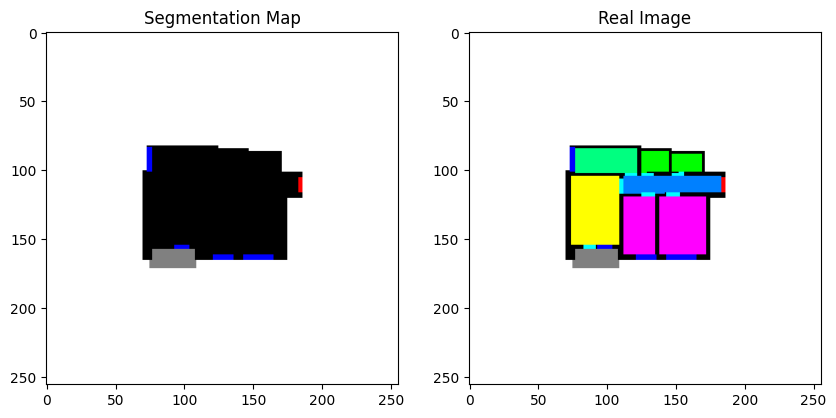

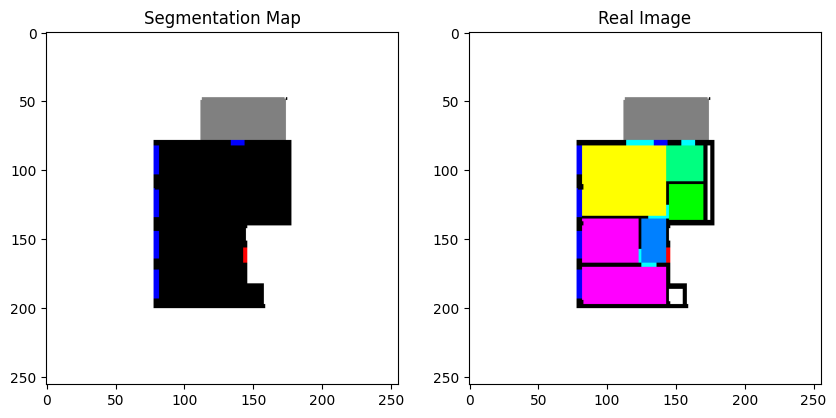

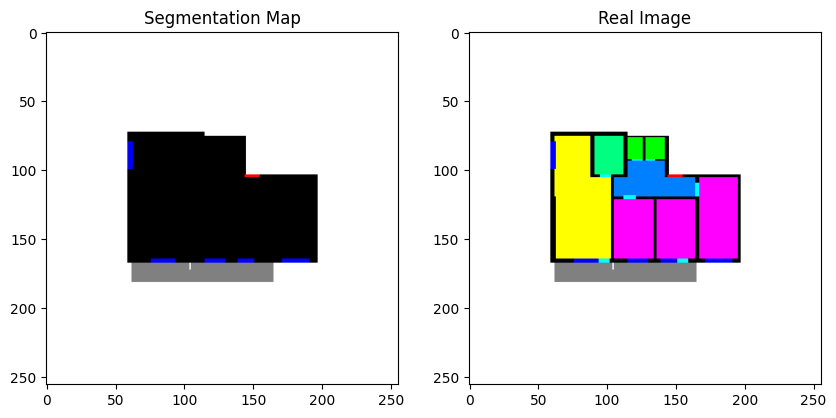

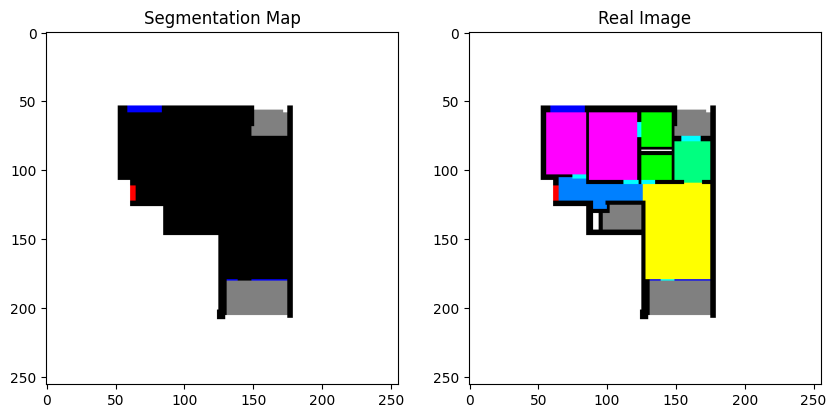

In [39]:
sample_train_batch = next(iter(train_dataset))
print(f"Segmentation map batch shape: {sample_train_batch[0].shape}.")
print(f"Image batch shape: {sample_train_batch[1].shape}.")
print(f"One-hot encoded label map shape: {sample_train_batch[2].shape}.")

# Plot a view samples from the training set.
for segmentation_map, real_image in zip(sample_train_batch[0], sample_train_batch[1]):
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1).set_title("Segmentation Map")
    plt.imshow((segmentation_map + 1) / 2)
    fig.add_subplot(1, 2, 2).set_title("Real Image")
    plt.imshow((real_image + 1) / 2)
    plt.show()

In [40]:

class SPADE(layers.Layer):
    def __init__(self, filters, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.epsilon = epsilon
        self.conv = layers.Conv2D(128, 3, padding="same", activation="relu")
        self.conv_gamma = layers.Conv2D(filters, 3, padding="same")
        self.conv_beta = layers.Conv2D(filters, 3, padding="same")

    def build(self, input_shape):
        self.resize_shape = input_shape[1:3]

    def call(self, input_tensor, raw_mask):
        mask = tf.image.resize(raw_mask, self.resize_shape, method="nearest")
        x = self.conv(mask)
        gamma = self.conv_gamma(x)
        beta = self.conv_beta(x)
        mean, var = tf.nn.moments(input_tensor, axes=(0, 1, 2), keepdims=True)
        std = tf.sqrt(var + self.epsilon)
        normalized = (input_tensor - mean) / std
        output = gamma * normalized + beta
        return output


class ResBlock(layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        input_filter = input_shape[-1]
        self.spade_1 = SPADE(input_filter)
        self.spade_2 = SPADE(self.filters)
        self.conv_1 = layers.Conv2D(self.filters, 3, padding="same")
        self.conv_2 = layers.Conv2D(self.filters, 3, padding="same")
        self.learned_skip = False

        if self.filters != input_filter:
            self.learned_skip = True
            self.spade_3 = SPADE(input_filter)
            self.conv_3 = layers.Conv2D(self.filters, 3, padding="same")

    def call(self, input_tensor, mask):
        x = self.spade_1(input_tensor, mask)
        x = self.conv_1(tf.nn.leaky_relu(x, 0.2))
        x = self.spade_2(x, mask)
        x = self.conv_2(tf.nn.leaky_relu(x, 0.2))
        skip = (
            self.conv_3(tf.nn.leaky_relu(self.spade_3(input_tensor, mask), 0.2))
            if self.learned_skip
            else input_tensor
        )
        output = skip + x
        return output


class GaussianSampler(layers.Layer):
    def __init__(self, batch_size, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.latent_dim = latent_dim

    def call(self, inputs):
        means, variance = inputs
        epsilon = tf.random.normal(
            shape=(self.batch_size, self.latent_dim), mean=0.0, stddev=1.0
        )
        samples = means + tf.exp(0.5 * variance) * epsilon
        return samples


In [41]:

def downsample(
    channels,
    kernels,
    strides=2,
    apply_norm=True,
    apply_activation=True,
    apply_dropout=False,
):
    block = keras.Sequential()
    block.add(
        layers.Conv2D(
            channels,
            kernels,
            strides=strides,
            padding="same",
            use_bias=False,
            kernel_initializer=keras.initializers.GlorotNormal(),
        )
    )
    if apply_norm:
        block.add(tfa.layers.InstanceNormalization())
    if apply_activation:
        block.add(layers.LeakyReLU(0.2))
    if apply_dropout:
        block.add(layers.Dropout(0.5))
    return block


In [42]:
# orginal:
# def build_encoder(image_shape, encoder_downsample_factor=64, latent_dim=256):
#     input_image = keras.Input(shape=image_shape)
#     x = downsample(encoder_downsample_factor, 3, apply_norm=False)(input_image)
#     x = downsample(2 * encoder_downsample_factor, 3)(x)
#     x = downsample(4 * encoder_downsample_factor, 3)(x)
#     x = downsample(8 * encoder_downsample_factor, 3)(x)
#     x = downsample(8 * encoder_downsample_factor, 3)(x)
#     x = layers.Flatten()(x)
#     mean = layers.Dense(latent_dim, name="mean")(x)
#     variance = layers.Dense(latent_dim, name="variance")(x)
#     return keras.Model(input_image, [mean, variance], name="encoder")

def build_encoder(image_shape, encoder_downsample_factor=64, latent_dim=LATENT_DIM):
    input_image = keras.Input(shape=image_shape)
    x = downsample(encoder_downsample_factor, 3, apply_norm=False)(input_image)
    x = downsample(2 * encoder_downsample_factor, 3)(x)
    x = downsample(4 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = downsample(8 * encoder_downsample_factor, 3)(x)
    x = layers.Flatten()(x)
    mean = layers.Dense(latent_dim, name="mean")(x)
    variance = layers.Dense(latent_dim, name="variance")(x)
    return keras.Model(input_image, [mean, variance], name="encoder")


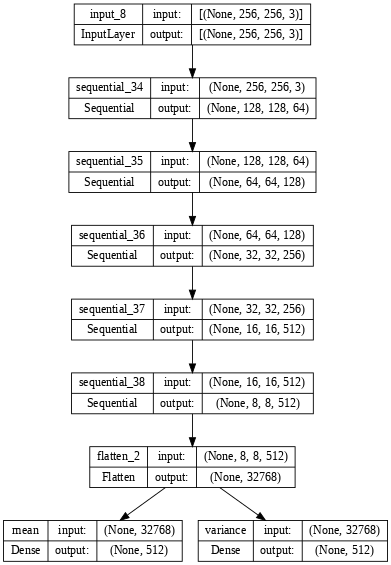

In [43]:
encoder = build_encoder((IMG_HEIGHT, IMG_HEIGHT, 3))
tf.keras.utils.plot_model(encoder, show_shapes=True, dpi=64)

In [44]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_34 (Sequential)  (None, 128, 128, 64)         1728      ['input_8[0][0]']             
                                                                                                  
 sequential_35 (Sequential)  (None, 64, 64, 128)          73984     ['sequential_34[0][0]']       
                                                                                                  
 sequential_36 (Sequential)  (None, 32, 32, 256)          295424    ['sequential_35[0][0]']       
                                                                                            

In [45]:
# orginal:
# def build_generator(mask_shape, latent_dim=256):
#     latent = keras.Input(shape=(latent_dim))
#     mask = keras.Input(shape=mask_shape)
#     x = layers.Dense(16384)(latent)
#     x = layers.Reshape((4, 4, 1024))(x)
#     x = ResBlock(filters=1024)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)
#     x = ResBlock(filters=1024)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)
#     x = ResBlock(filters=1024)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)
#     x = ResBlock(filters=512)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)
#     x = ResBlock(filters=256)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)
#     x = ResBlock(filters=128)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)
#     x = tf.nn.leaky_relu(x, 0.2)
#     output_image = tf.nn.tanh(layers.Conv2D(3, 4, padding="same")(x))
#     return keras.Model([latent, mask], output_image, name="generator")

# def build_generator(mask_shape, latent_dim=LATENT_DIM):
#     latent = keras.Input(shape=(latent_dim))
#     mask = keras.Input(shape=mask_shape)

#     x = layers.Dense(16384)(latent)
#     x = layers.Reshape((4, 4, 1024))(x)

#     x = ResBlock(filters=2048)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)

#     x = ResBlock(filters=1024)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)

#     x = ResBlock(filters=1024)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)

#     x = ResBlock(filters=512)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)

#     x = ResBlock(filters=256)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)

#     x = ResBlock(filters=128)(x, mask)
#     x = layers.UpSampling2D((2, 2))(x)

#     x = tf.nn.leaky_relu(x, 0.2)
#     output_image = tf.nn.tanh(layers.Conv2D(3, 4, padding="same")(x))

#     return keras.Model([latent, mask], output_image, name="generator")


### experimental generator with convolutions over mask
def build_generator(mask_shape, latent_dim=LATENT_DIM):
    latent = keras.Input(shape=(latent_dim))
    mask = keras.Input(shape=mask_shape)

    m1 = downsample(64, 3, strides=2)(mask)
    m2 = downsample(128, 3, strides=2)(m1)
    m3 = downsample(256, 3, strides=2)(m2)
    m4 = downsample(512, 3, strides=2)(m3)
    m5 = downsample(1024, 3, strides=2)(m4)

    x = layers.Dense(16384)(latent)
    x = layers.Reshape((4, 4, 1024))(x)

    x = ResBlock(filters=1024)(x, m5)
    x = layers.UpSampling2D((2, 2))(x)

    x = ResBlock(filters=1024)(x, m4)
    x = layers.UpSampling2D((2, 2))(x)

    x = ResBlock(filters=1024)(x, m3)
    x = layers.UpSampling2D((2, 2))(x)

    x = ResBlock(filters=512)(x, m2)
    x = layers.UpSampling2D((2, 2))(x)

    x = ResBlock(filters=256)(x, m1)
    x = layers.UpSampling2D((2, 2))(x)

    x = ResBlock(filters=128)(x, mask)
    x = layers.UpSampling2D((2, 2))(x)

    x = tf.nn.leaky_relu(x, 0.2)
    output_image = tf.nn.tanh(layers.Conv2D(3, 4, padding="same")(x))

    return keras.Model([latent, mask], output_image, name="generator")

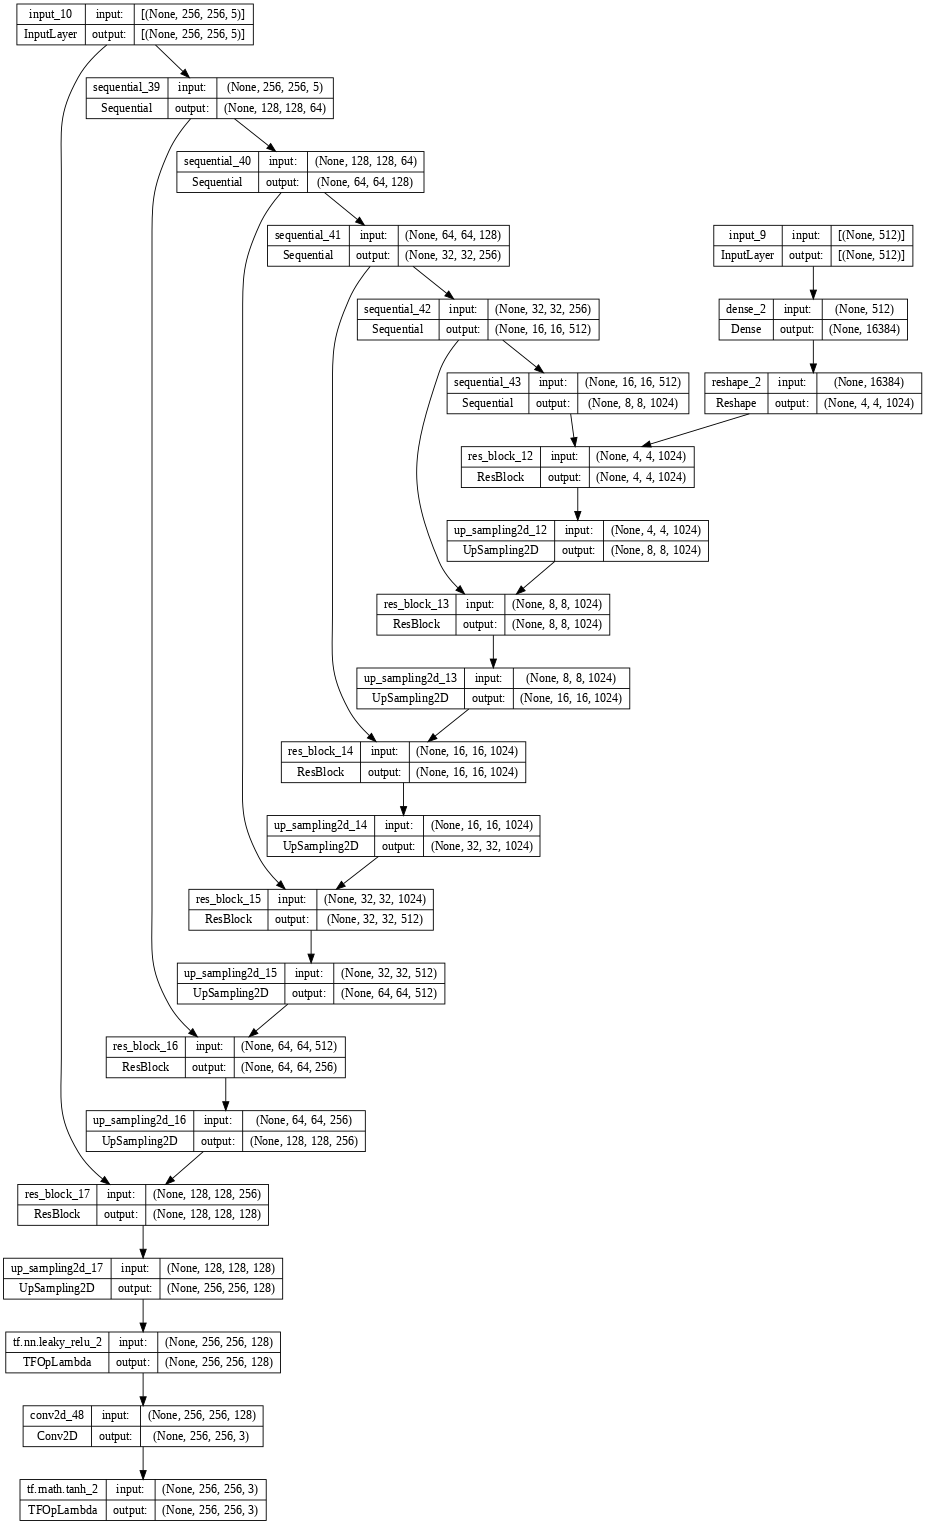

In [46]:
generator = build_generator((IMG_HEIGHT, IMG_HEIGHT, NUM_CLASSES))
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [47]:
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 5)]        0         []                            
                                                                                                  
 sequential_39 (Sequential)  (None, 128, 128, 64)         3008      ['input_10[0][0]']            
                                                                                                  
 sequential_40 (Sequential)  (None, 64, 64, 128)          73984     ['sequential_39[0][0]']       
                                                                                                  
 input_9 (InputLayer)        [(None, 512)]                0         []                            
                                                                                          

In [48]:
# orginal:
# def build_discriminator(image_shape, downsample_factor=64):
#     input_image_A = keras.Input(shape=image_shape, name="discriminator_image_A")
#     input_image_B = keras.Input(shape=image_shape, name="discriminator_image_B")
#     x = layers.Concatenate()([input_image_A, input_image_B])
#     x1 = downsample(downsample_factor, 4, apply_norm=False)(x)
#     x2 = downsample(2 * downsample_factor, 4)(x1)
#     x3 = downsample(4 * downsample_factor, 4)(x2)
#     x4 = downsample(8 * downsample_factor, 4, strides=1)(x3)
#     x5 = layers.Conv2D(1, 4)(x4)
#     outputs = [x1, x2, x3, x4, x5]
#     return keras.Model([input_image_A, input_image_B], outputs)

# def build_discriminator(image_shape, downsample_factor=128):
#     input_image_A = keras.Input(shape=image_shape, name="discriminator_image_A")
#     input_image_B = keras.Input(shape=image_shape, name="discriminator_image_B")
#     x = layers.Concatenate()([input_image_A, input_image_B])
#     x1 = downsample(downsample_factor, 4, apply_norm=False)(x)

#     x2 = downsample(2 * downsample_factor, 4)(x1)
#     x3 = downsample(2 * downsample_factor, 4, strides=1)(x2)

#     x4 = downsample(4 * downsample_factor, 4)(x3)
#     x5 = downsample(4 * downsample_factor, 4, strides=1)(x4)

#     x6 = downsample(8 * downsample_factor, 4, strides=1, apply_dropout=True)(x5)
#     x7 = downsample(8 * downsample_factor, 4, strides=1, apply_dropout=True)(x6)

#     x8 = layers.Conv2D(1, 4)(x7)
#     outputs = [x1, x2, x3, x4, x5, x6, x7, x8]
#     return keras.Model([input_image_A, input_image_B], outputs)

### experimental discriminator
def build_discriminator(image_shape, downsample_factor=128):
    input_image_A = keras.Input(shape=image_shape, name="discriminator_image_A")
    input_image_B = keras.Input(shape=image_shape, name="discriminator_image_B")
    x = layers.Concatenate()([input_image_A, input_image_B])
    x1 = downsample(downsample_factor, 4, apply_norm=False)(x)

    x2 = downsample(2 * downsample_factor, 4)(x1)
    x3 = downsample(2 * downsample_factor, 4, strides=1)(x2)

    x4 = downsample(4 * downsample_factor, 4)(x3)
    x5 = downsample(4 * downsample_factor, 4, strides=1)(x4)

    x6 = downsample(8 * downsample_factor, 4, strides=1, apply_dropout=True)(x5)
    x7 = downsample(8 * downsample_factor, 4, strides=1, apply_dropout=True)(x6)

    x8 = layers.Conv2D(1, 4)(x7)
    outputs = [x1, x2, x3, x4, x5, x6, x7, x8]
    return keras.Model([input_image_A, input_image_B], outputs)


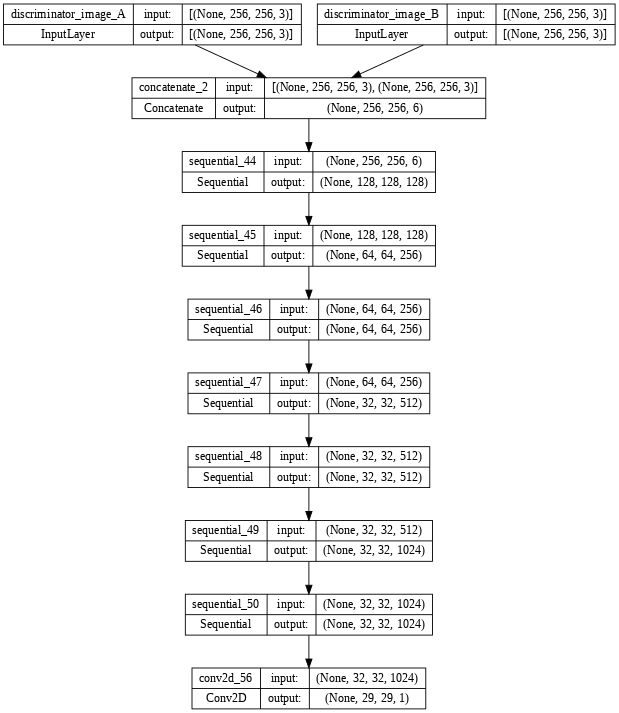

In [49]:
discriminator = build_discriminator((IMG_HEIGHT, IMG_HEIGHT, 3))
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [50]:
discriminator.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 discriminator_image_A (Inp  [(None, 256, 256, 3)]        0         []                            
 utLayer)                                                                                         
                                                                                                  
 discriminator_image_B (Inp  [(None, 256, 256, 3)]        0         []                            
 utLayer)                                                                                         
                                                                                                  
 concatenate_2 (Concatenate  (None, 256, 256, 6)          0         ['discriminator_image_A[0][0]'
 )                                                                  , 'discriminator_image_B

In [51]:

def generator_loss(y):
    return -tf.reduce_mean(y)


def kl_divergence_loss(mean, variance):
    return -0.5 * tf.reduce_sum(1 + variance - tf.square(mean) - tf.exp(variance))


class FeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        loss = 0
        for i in range(len(y_true) - 1):
            loss += self.mae(y_true[i], y_pred[i])
        return loss


class VGGFeatureMatchingLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder_layers = [
            "block1_conv1",
            "block2_conv1",
            "block3_conv1",
            "block4_conv1",
            "block5_conv1",
        ]
        self.weights = [1.0 / 32, 1.0 / 16, 1.0 / 8, 1.0 / 4, 1.0]
        vgg = keras.applications.VGG19(include_top=False, weights="imagenet")
        layer_outputs = [vgg.get_layer(x).output for x in self.encoder_layers]
        self.vgg_model = keras.Model(vgg.input, layer_outputs, name="VGG")
        self.mae = keras.losses.MeanAbsoluteError()

    def call(self, y_true, y_pred):
        y_true = keras.applications.vgg19.preprocess_input(127.5 * (y_true + 1))
        y_pred = keras.applications.vgg19.preprocess_input(127.5 * (y_pred + 1))
        real_features = self.vgg_model(y_true)
        fake_features = self.vgg_model(y_pred)
        loss = 0
        for i in range(len(real_features)):
            loss += self.weights[i] * self.mae(real_features[i], fake_features[i])
        return loss


class DiscriminatorLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hinge_loss = keras.losses.Hinge()

    def call(self, y, is_real):
        label = 1.0 if is_real else -1.0
        return self.hinge_loss(label, y)


In [52]:
class GanMonitor(keras.callbacks.Callback):
    def __init__(self, val_dataset, n_samples, epoch_interval=5):
        self.val_images = next(iter(val_dataset))
        self.n_samples = n_samples
        self.epoch_interval = epoch_interval

    def infer(self):
        latent_vector = tf.random.normal(
            shape=(self.model.batch_size, self.model.latent_dim), mean=0.0, stddev=2.0
        )
        return self.model.predict([latent_vector, self.val_images[2]])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            generated_images = self.infer()
            for _ in range(self.n_samples):
                grid_row = min(generated_images.shape[0], 3)
                f, axarr = plt.subplots(grid_row, 3, figsize=(18, grid_row * 6))
                for row in range(grid_row):
                    ax = axarr if grid_row == 1 else axarr[row]
                    ax[0].imshow((self.val_images[0][row] + 1) / 2)
                    ax[0].axis("off")
                    ax[0].set_title("Mask", fontsize=20)
                    ax[1].imshow((self.val_images[1][row] + 1) / 2)
                    ax[1].axis("off")
                    ax[1].set_title("Ground Truth", fontsize=20)
                    ax[2].imshow((generated_images[row] + 1) / 2)
                    ax[2].axis("off")
                    ax[2].set_title("Generated", fontsize=20)
                plt.show()


In [53]:
class GauGAN(keras.Model):
    def __init__(
        self,
        image_size,
        num_classes,
        batch_size,
        latent_dim,
        feature_loss_coeff=10,
        vgg_feature_loss_coeff=0.1,
        kl_divergence_loss_coeff=0.1,
        **kwargs,
    ):
        super().__init__(**kwargs)

        self.image_size = image_size
        self.latent_dim = latent_dim
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.image_shape = (image_size, image_size, 3)
        self.mask_shape = (image_size, image_size, num_classes)
        self.feature_loss_coeff = feature_loss_coeff
        self.vgg_feature_loss_coeff = vgg_feature_loss_coeff
        self.kl_divergence_loss_coeff = kl_divergence_loss_coeff

        self.discriminator = build_discriminator(self.image_shape)
        self.generator = build_generator(self.mask_shape)
        self.encoder = build_encoder(self.image_shape)
        self.sampler = GaussianSampler(batch_size, latent_dim)
        self.patch_size, self.combined_model = self.build_combined_generator()

        self.disc_loss_tracker = tf.keras.metrics.Mean(name="disc_loss")
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="gen_loss")
        self.feat_loss_tracker = tf.keras.metrics.Mean(name="feat_loss")
        self.vgg_loss_tracker = tf.keras.metrics.Mean(name="vgg_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.disc_loss_tracker,
            self.gen_loss_tracker,
            self.feat_loss_tracker,
            self.vgg_loss_tracker,
            self.kl_loss_tracker,
        ]

    def build_combined_generator(self):
        self.discriminator.trainable = False
        mask_input = keras.Input(shape=self.mask_shape, name="mask")
        image_input = keras.Input(shape=self.image_shape, name="image")
        latent_input = keras.Input(shape=(self.latent_dim), name="latent")
        generated_image = self.generator([latent_input, mask_input])
        discriminator_output = self.discriminator([image_input, generated_image])
        patch_size = discriminator_output[-1].shape[1]
        combined_model = keras.Model(
            [latent_input, mask_input, image_input],
            [discriminator_output, generated_image],
        )
        return patch_size, combined_model

    def compile(self, gen_lr=1e-4, disc_lr=4e-4, **kwargs):
        super().compile(**kwargs)
        self.generator_optimizer = keras.optimizers.Adam(
            gen_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_optimizer = keras.optimizers.Adam(
            disc_lr, beta_1=0.0, beta_2=0.999
        )
        self.discriminator_loss = DiscriminatorLoss()
        self.feature_matching_loss = FeatureMatchingLoss()
        self.vgg_loss = VGGFeatureMatchingLoss()

    def train_discriminator(self, latent_vector, segmentation_map, real_image, labels):
        fake_images = self.generator([latent_vector, labels])
        with tf.GradientTape() as gradient_tape:
            pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
            pred_real = self.discriminator([segmentation_map, real_image])[-1]
            loss_fake = self.discriminator_loss(pred_fake, False)
            loss_real = self.discriminator_loss(pred_real, True)
            total_loss = 0.5 * (loss_fake + loss_real)

        self.discriminator.trainable = True
        gradients = gradient_tape.gradient(
            total_loss, self.discriminator.trainable_variables
        )
        self.discriminator_optimizer.apply_gradients(
            zip(gradients, self.discriminator.trainable_variables)
        )
        return total_loss

    def train_generator(
        self, latent_vector, segmentation_map, labels, image, mean, variance
    ):
        self.discriminator.trainable = False
        with tf.GradientTape() as tape:
            real_d_output = self.discriminator([segmentation_map, image])
            fake_d_output, fake_image = self.combined_model(
                [latent_vector, labels, segmentation_map]
            )
            pred = fake_d_output[-1]

            # Compute generator losses.
            g_loss = generator_loss(pred)
            kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
            vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
            feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
                real_d_output, fake_d_output
            )
            total_loss = g_loss + kl_loss + vgg_loss + feature_loss

        all_trainable_variables = (
            self.combined_model.trainable_variables + self.encoder.trainable_variables
        )

        gradients = tape.gradient(total_loss, all_trainable_variables)
        self.generator_optimizer.apply_gradients(
            zip(gradients, all_trainable_variables)
        )
        return total_loss, feature_loss, vgg_loss, kl_loss

    def train_step(self, data):
        segmentation_map, image, labels = data
        mean, variance = self.encoder(image)
        latent_vector = self.sampler([mean, variance])
        discriminator_loss = self.train_discriminator(
            latent_vector, segmentation_map, image, labels
        )
        (generator_loss, feature_loss, vgg_loss, kl_loss) = self.train_generator(
            latent_vector, segmentation_map, labels, image, mean, variance
        )

        self.disc_loss_tracker.update_state(discriminator_loss)
        self.gen_loss_tracker.update_state(generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        segmentation_map, image, labels = data

        mean, variance = self.encoder(image)

        latent_vector = self.sampler([mean, variance])

        fake_images = self.generator([latent_vector, labels])

        pred_fake = self.discriminator([segmentation_map, fake_images])[-1]
        pred_real = self.discriminator([segmentation_map, image])[-1]
        loss_fake = self.discriminator_loss(pred_fake, False)
        loss_real = self.discriminator_loss(pred_real, True)
        total_discriminator_loss = 0.5 * (loss_fake + loss_real)
        real_d_output = self.discriminator([segmentation_map, image])
        fake_d_output, fake_image = self.combined_model(
            [latent_vector, labels, segmentation_map]
        )
        pred = fake_d_output[-1]
        g_loss = generator_loss(pred)
        kl_loss = self.kl_divergence_loss_coeff * kl_divergence_loss(mean, variance)
        vgg_loss = self.vgg_feature_loss_coeff * self.vgg_loss(image, fake_image)
        feature_loss = self.feature_loss_coeff * self.feature_matching_loss(
            real_d_output, fake_d_output
        )
        total_generator_loss = g_loss + kl_loss + vgg_loss + feature_loss

        # Report progress.
        self.disc_loss_tracker.update_state(total_discriminator_loss)
        self.gen_loss_tracker.update_state(total_generator_loss)
        self.feat_loss_tracker.update_state(feature_loss)
        self.vgg_loss_tracker.update_state(vgg_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        latent_vectors, labels = inputs
        return self.generator([latent_vectors, labels])


In [54]:
class SaveCheckpoint(keras.callbacks.Callback):
    def __init__(self, epoch_interval=1):
        self.epoch_interval = epoch_interval
        self.checkpoint_dir = CHECKPOINT_DIR

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.epoch_interval == 0:
            now_str = datetime.datetime.now().strftime("%Y%m%d_%H-%M-%S")
            checkpoint_path = os.path.join(self.checkpoint_dir, f"ckpt_epoch_{now_str}.ckpt")

            checkpoint = tf.train.Checkpoint(
                generator_optimizer=self.model.generator_optimizer,
                discriminator_optimizer=self.model.discriminator_optimizer,
                generator=self.model.generator,
                discriminator=self.model.discriminator,
                encoder=self.model.encoder,
                sampler=self.model.sampler,
                combined_model = self.model.combined_model
                )
            checkpoint.save(file_prefix=checkpoint_path)


## GauGAN training

In [55]:
gaugan = GauGAN(IMG_HEIGHT, NUM_CLASSES, BATCH_SIZE, latent_dim=LATENT_DIM)
gaugan.compile( gen_lr=1e-4, disc_lr=2e-4)

In [56]:
checkpoint = tf.train.Checkpoint(generator_optimizer=gaugan.generator_optimizer,
                                discriminator_optimizer=gaugan.discriminator_optimizer,
                                generator=gaugan.generator,
                                discriminator=gaugan.discriminator,
                                encoder = gaugan.encoder,
                                sampler = gaugan.sampler,
                                combined_model = gaugan.combined_model)

In [57]:
checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_DIR))
# checkpoint.restore( checkpoint_dir + "/ckpt-20")

Epoch 1/10


4711/4711 [==============================] - ETA: 0s - disc_loss: 0.5850 - gen_loss: 191.5716 - feat_loss: 9.5167 - vgg_loss: 7.7411 - kl_loss: 172.8523

1/1 [==============================] - 1s 1s/step


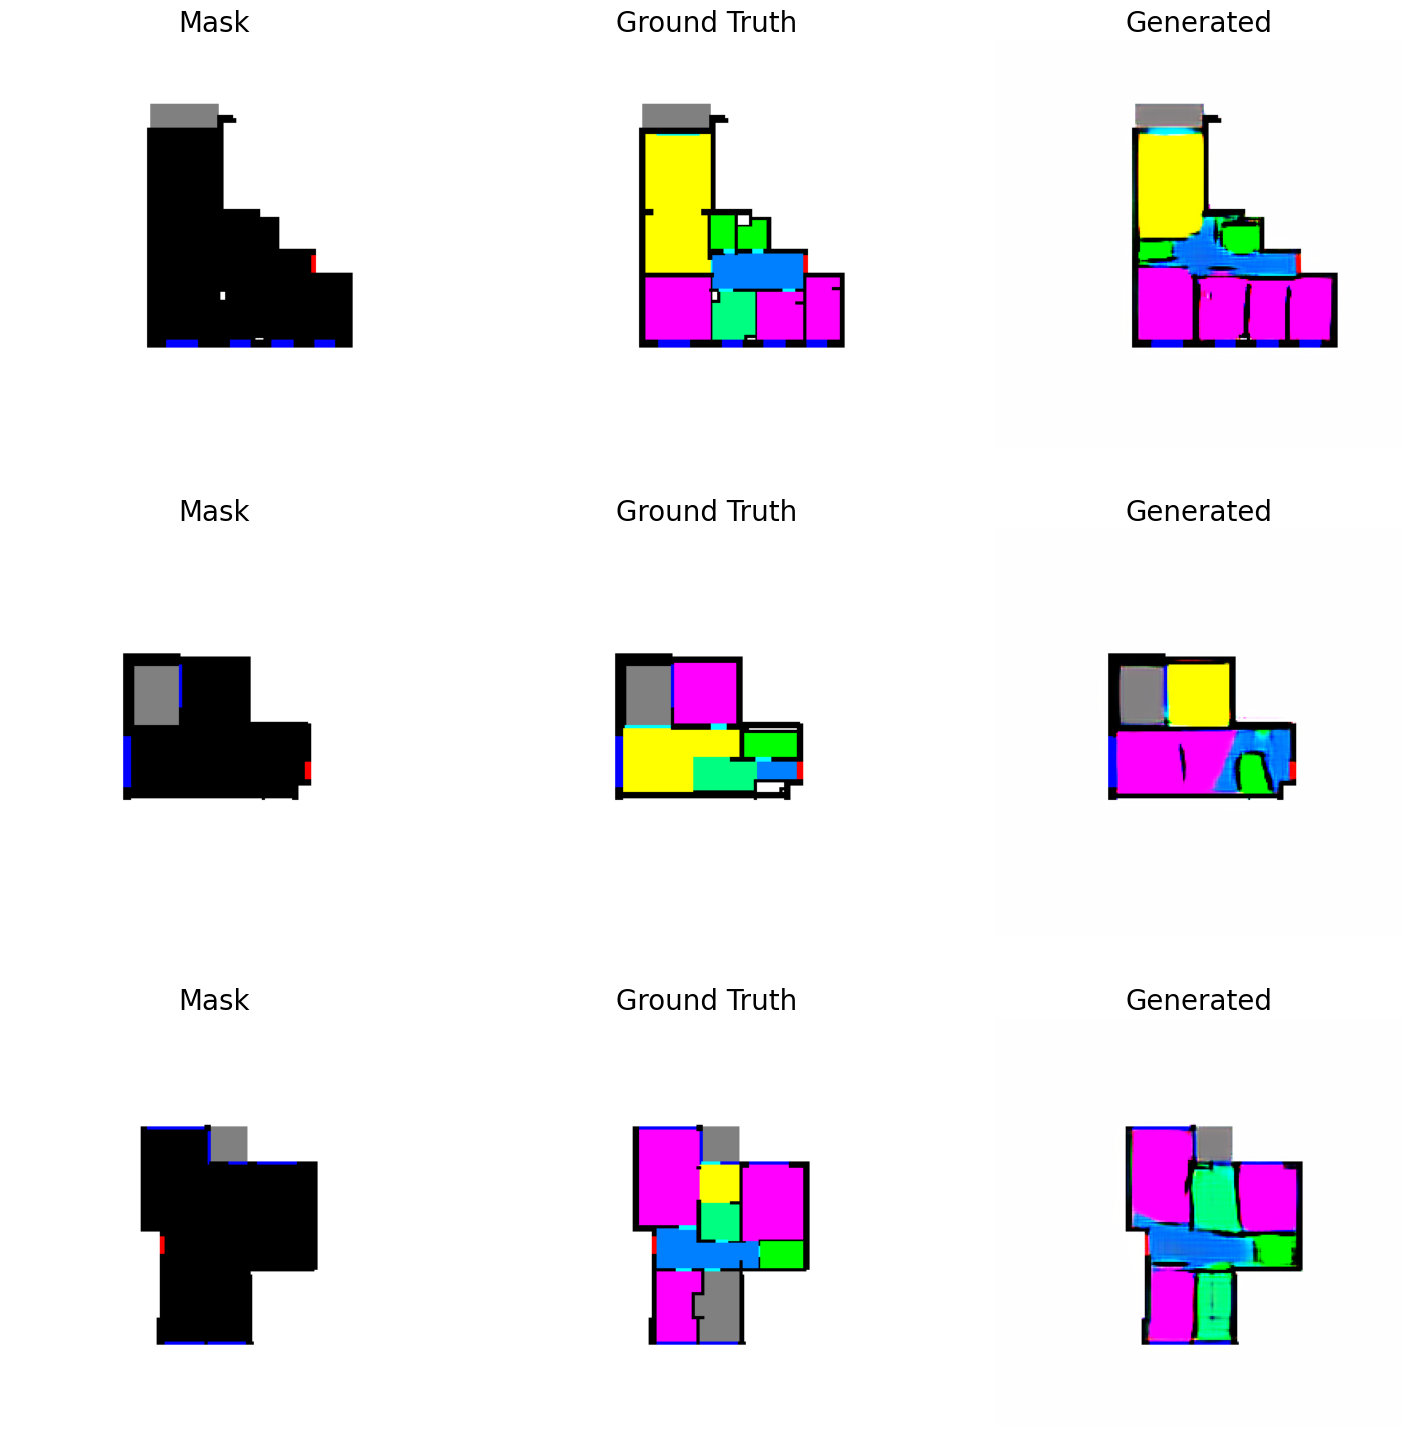

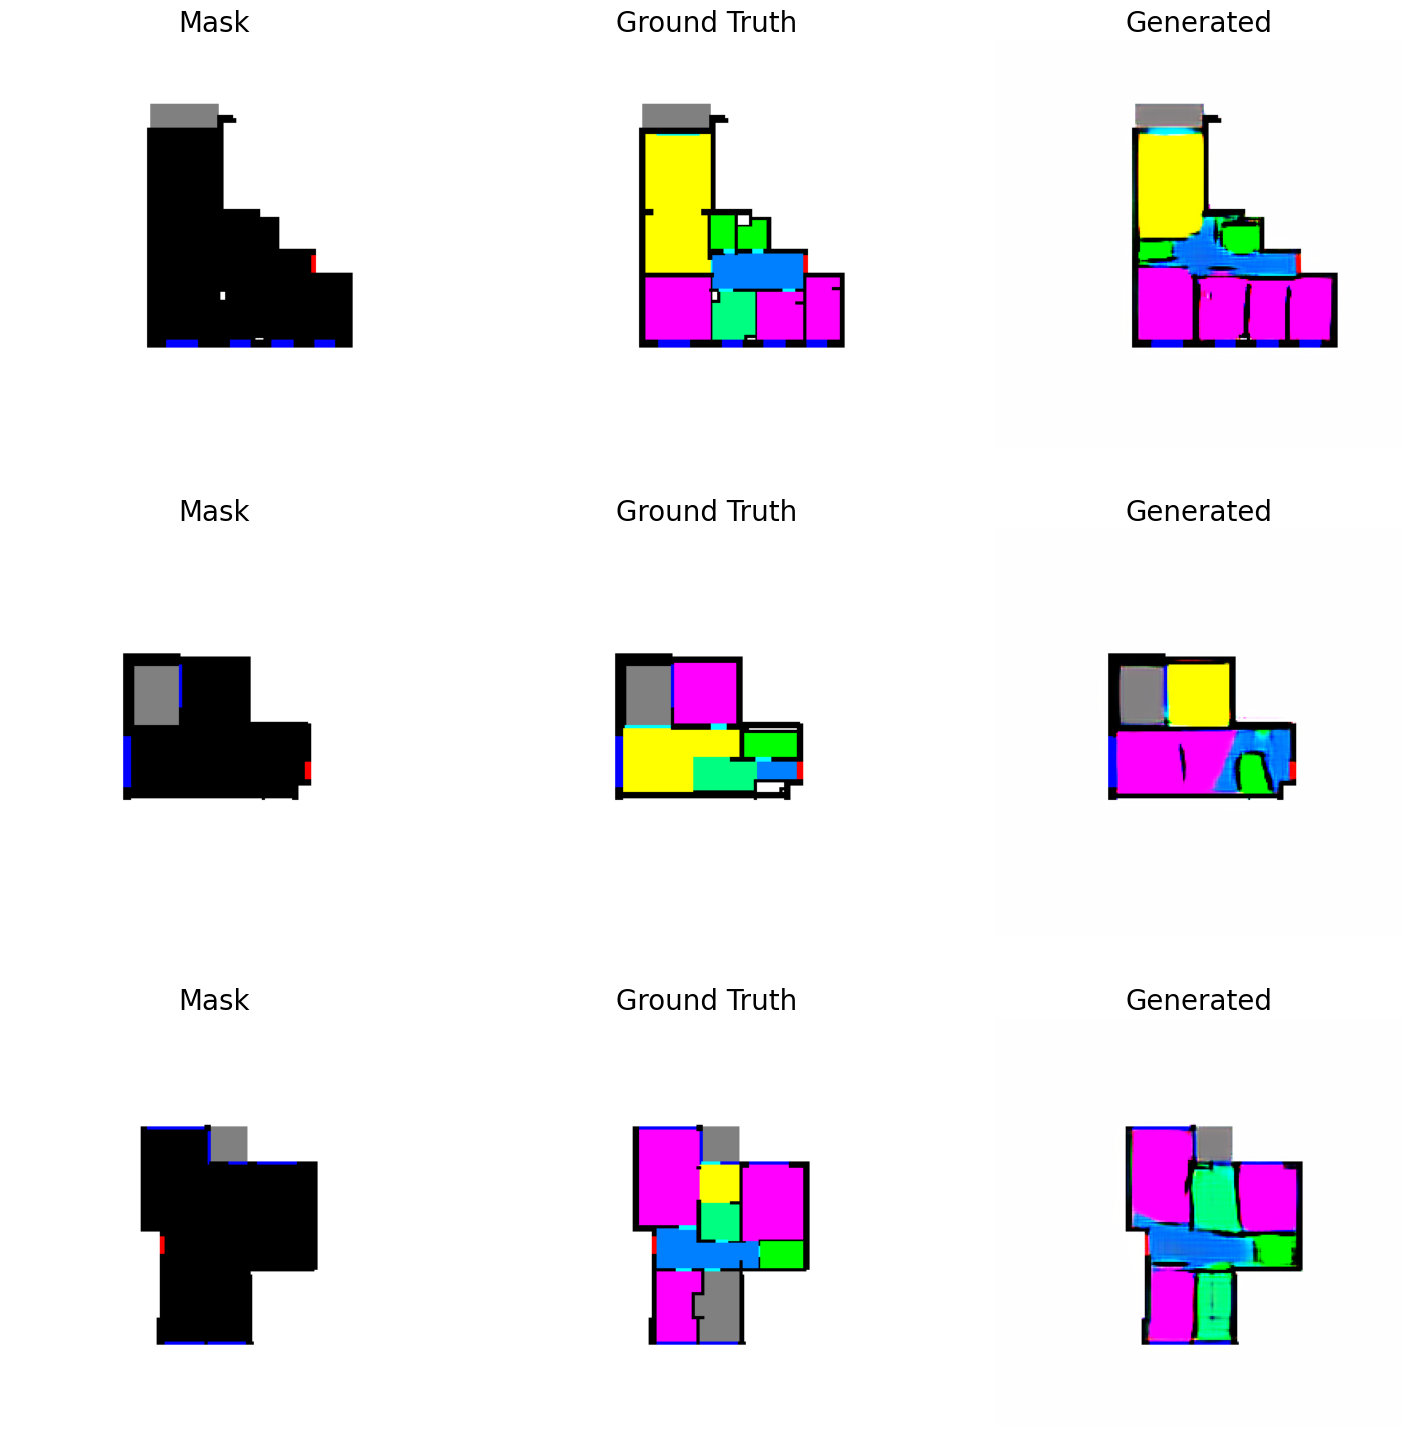

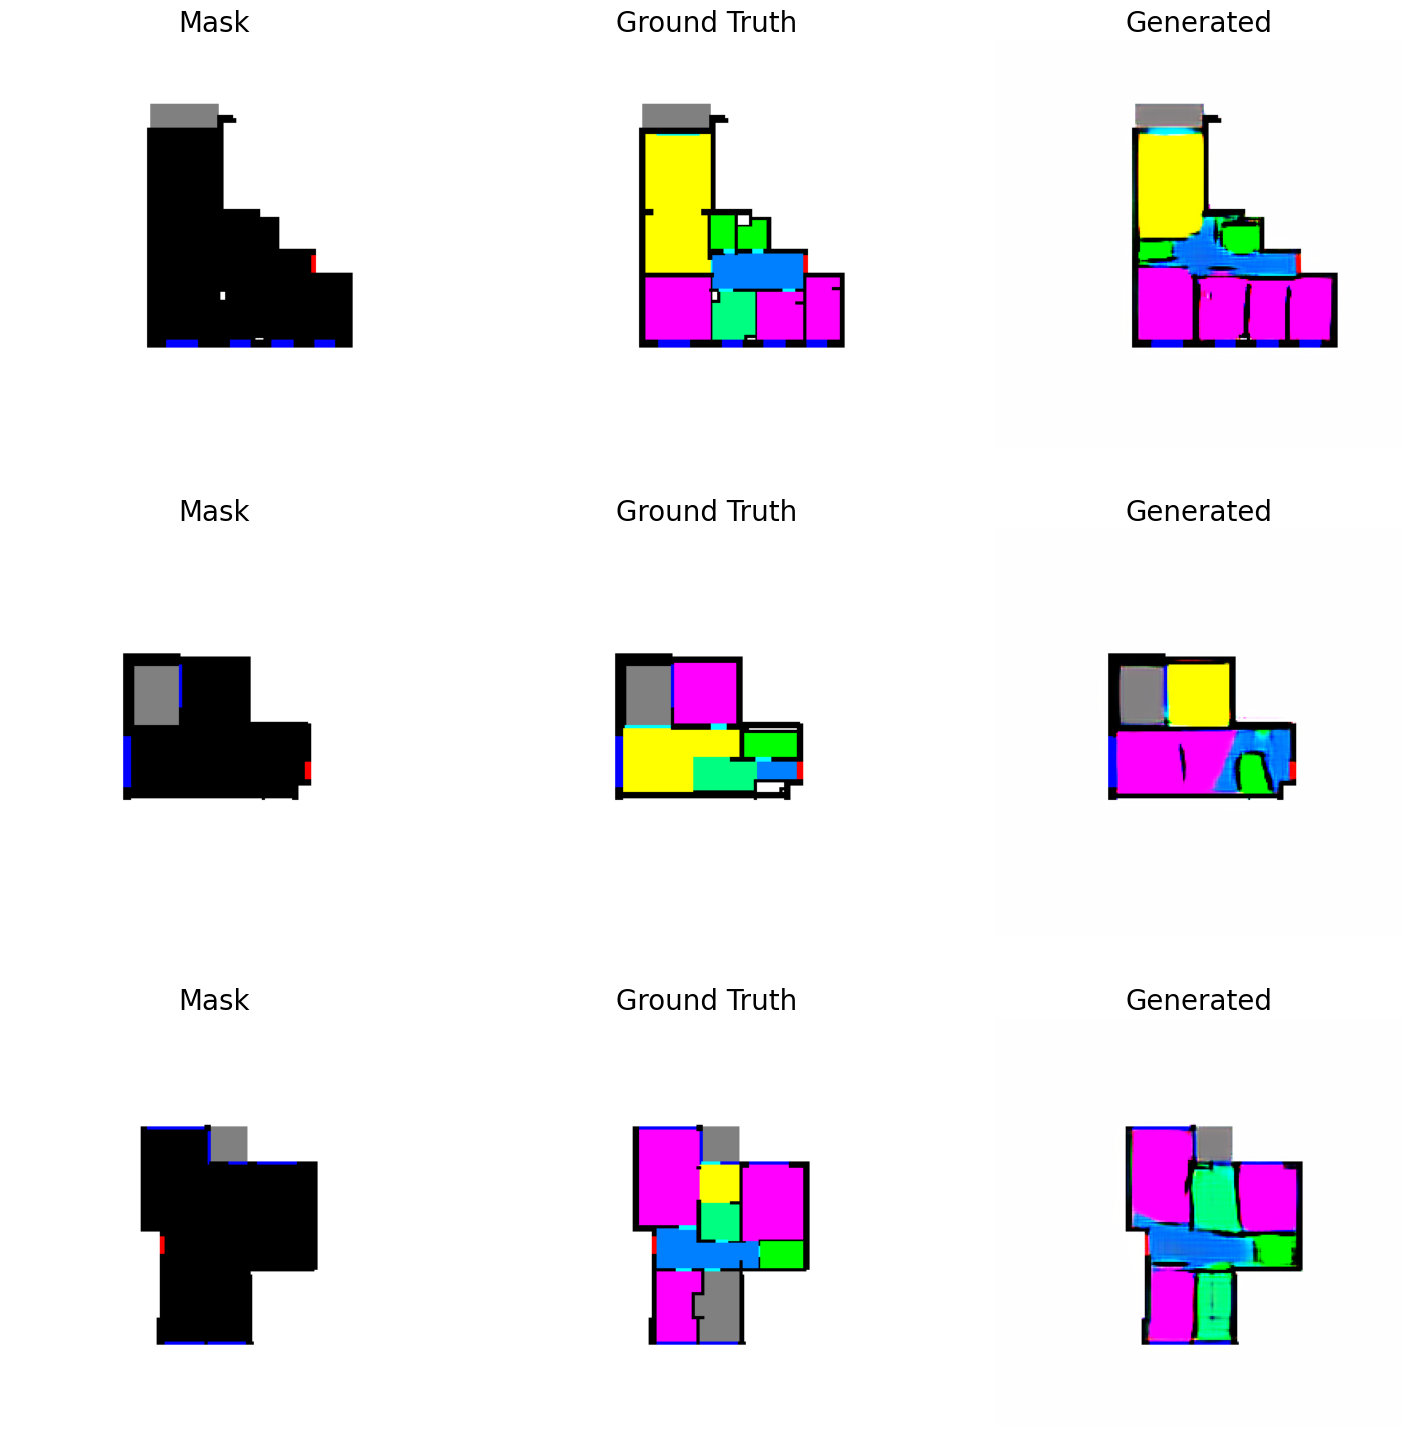

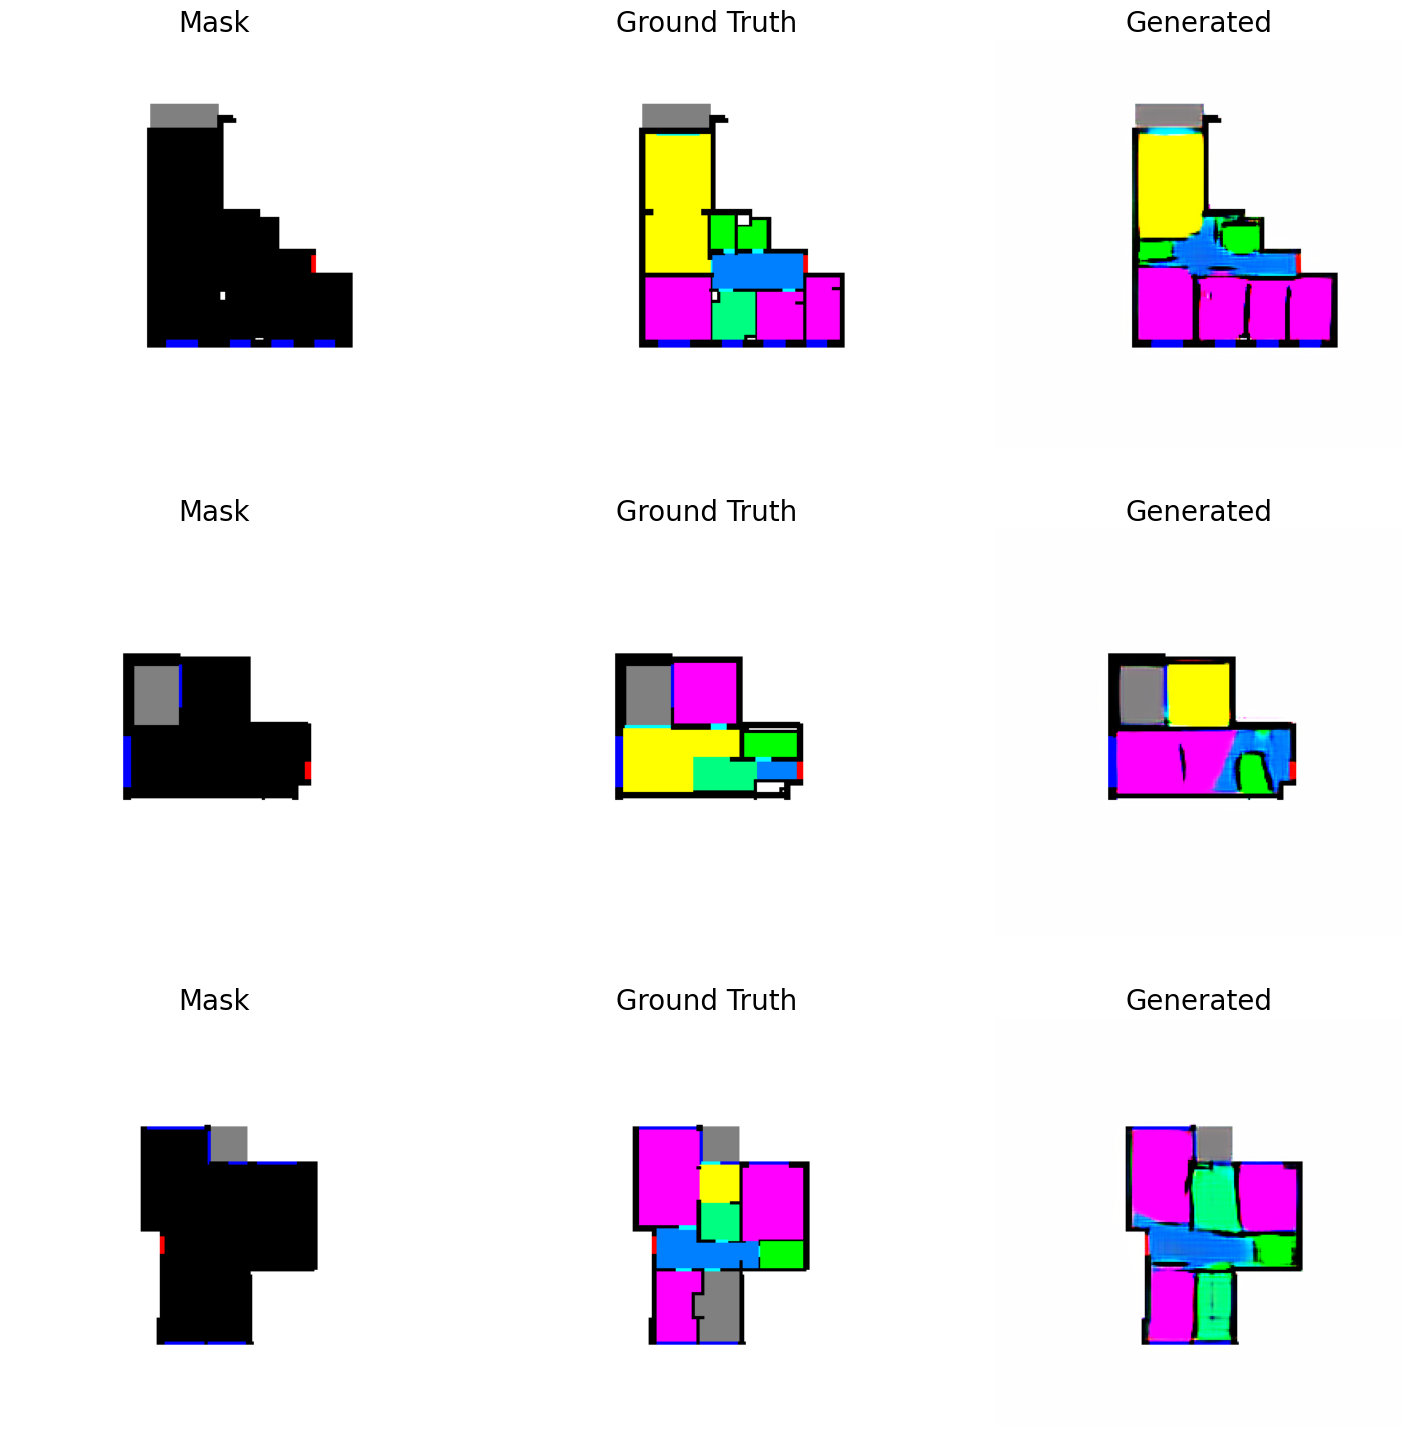

4711/4711 [==============================] - 8016s 2s/step - disc_loss: 0.5850 - gen_loss: 191.5716 - feat_loss: 9.5167 - vgg_loss: 7.7411 - kl_loss: 172.8523 - val_disc_loss: 0.7630 - val_gen_loss: 188.7159 - val_feat_loss: 9.0302 - val_vgg_loss: 7.5514 - val_kl_loss: 172.4884
Epoch 2/10
4711/4711 [==============================] - ETA: 0s - disc_loss: 0.2422 - gen_loss: 192.7134 - feat_loss: 9.5986 - vgg_loss: 7.4189 - kl_loss: 172.9157

1/1 [==============================] - 0s 30ms/step


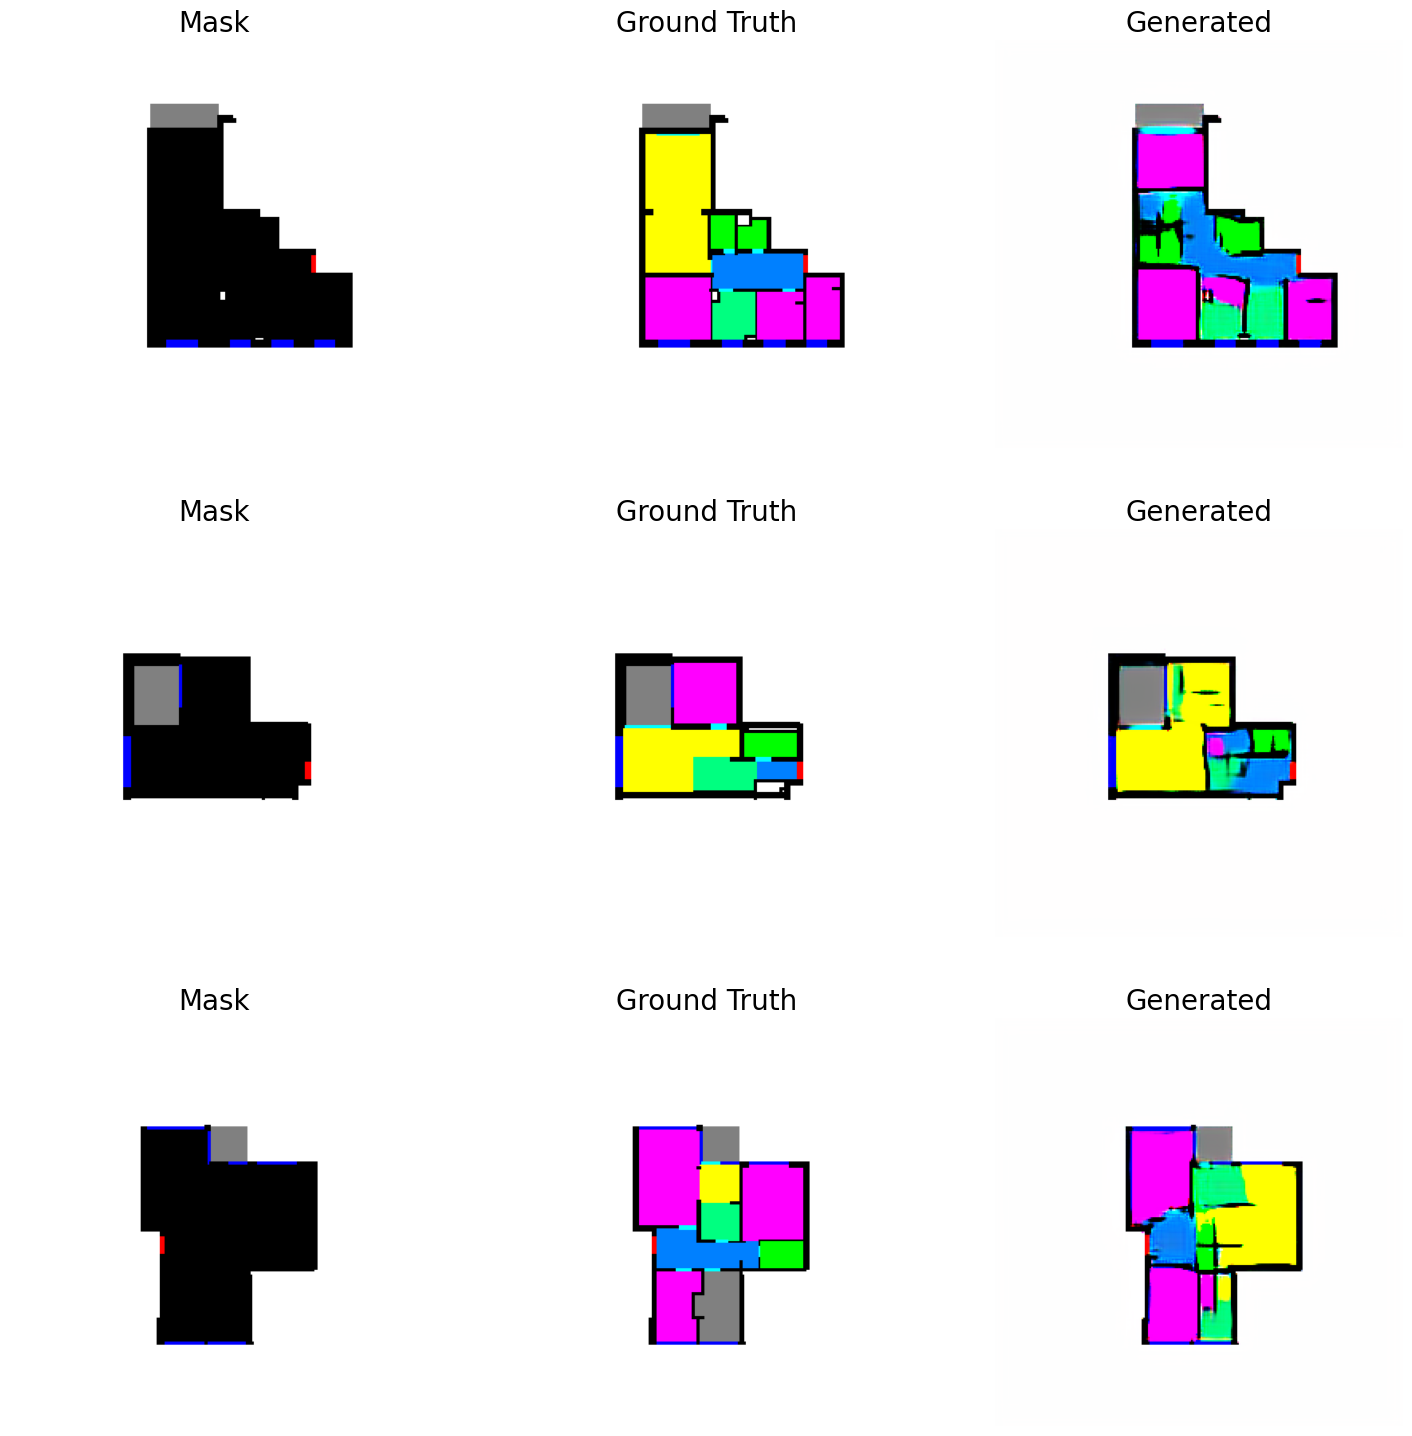

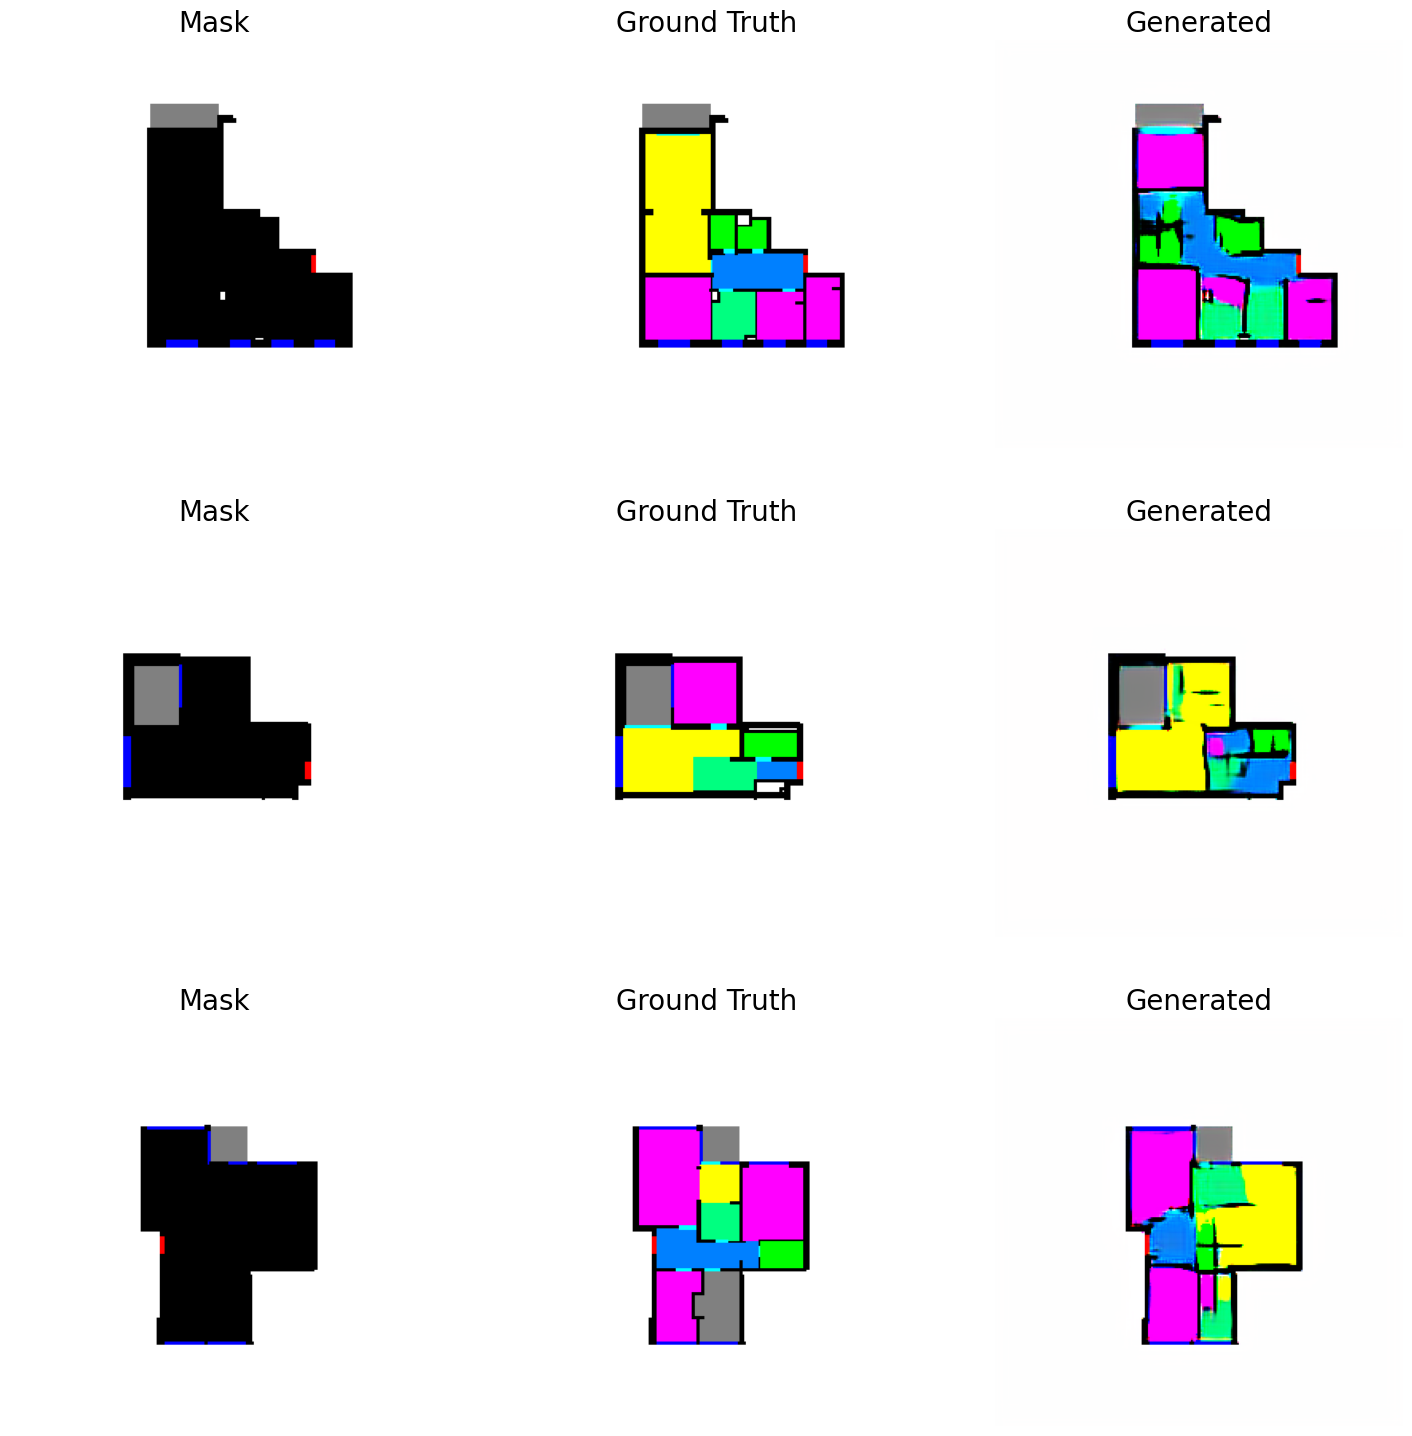

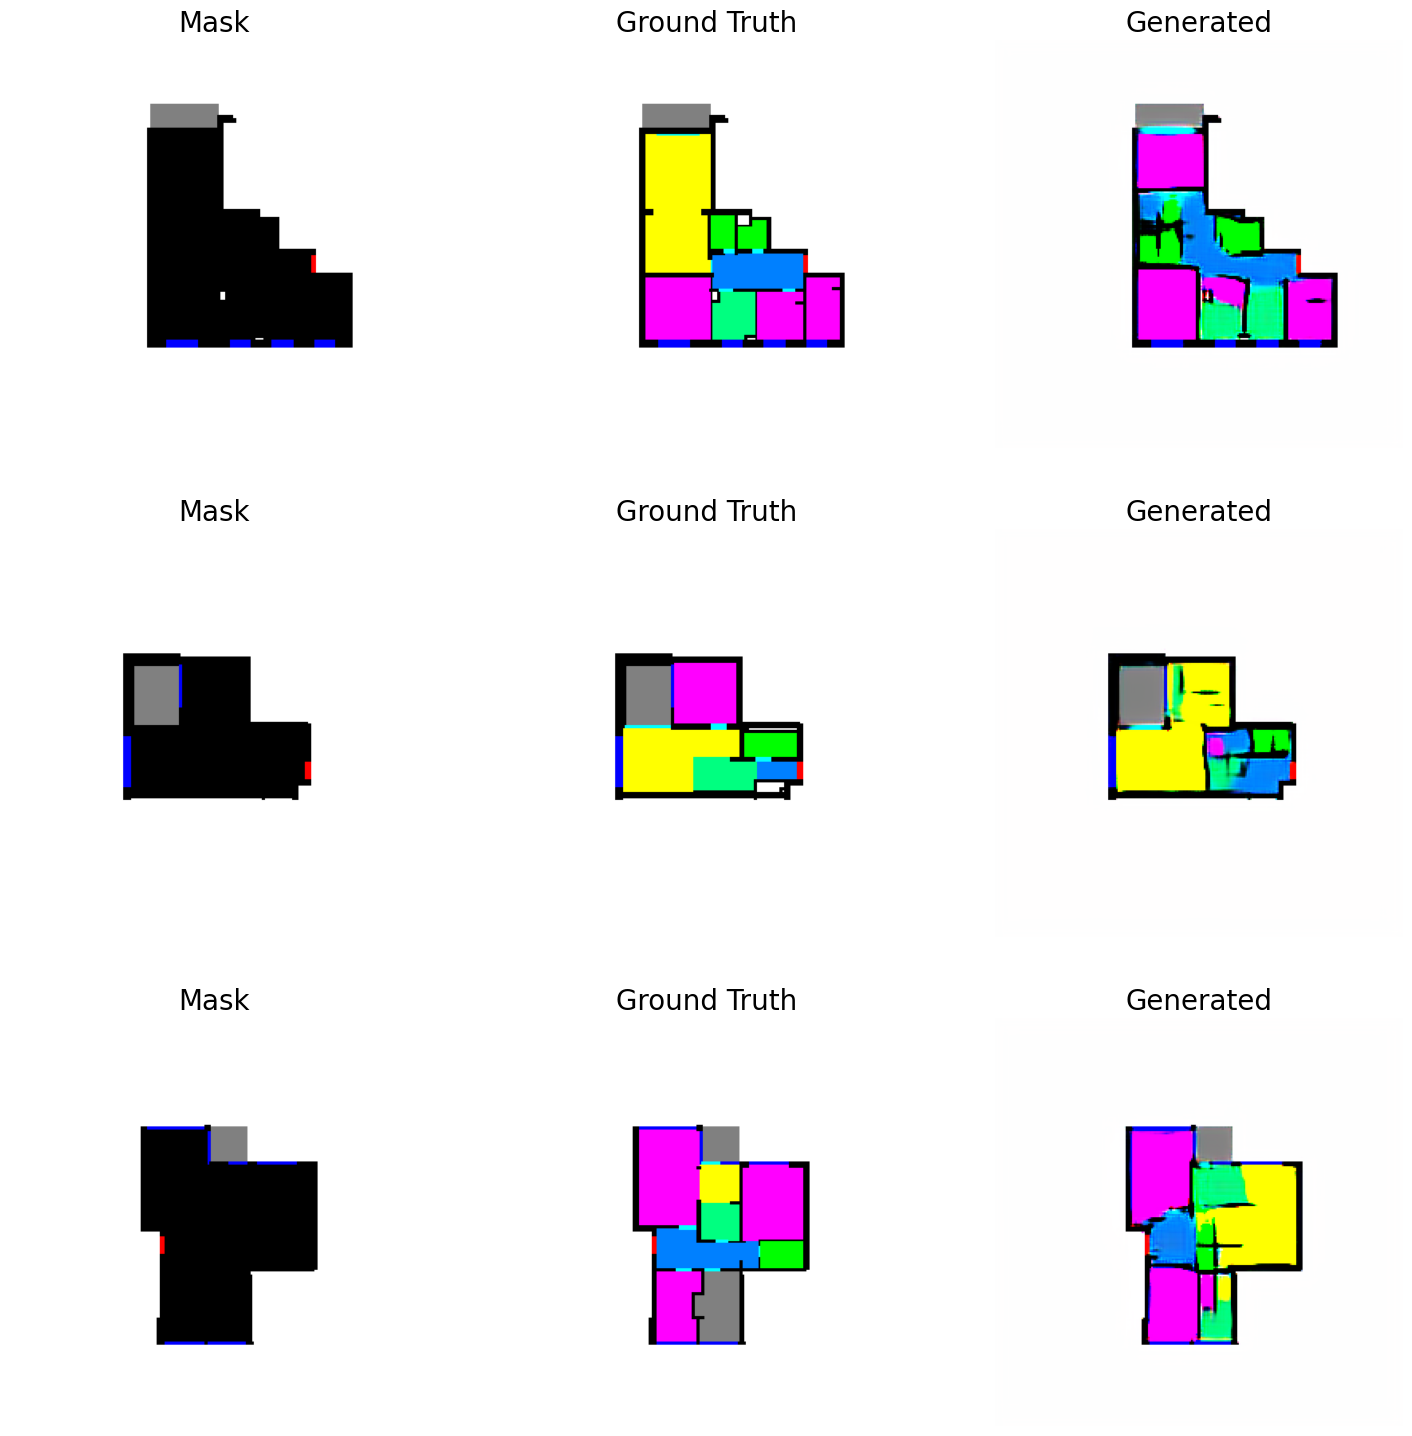

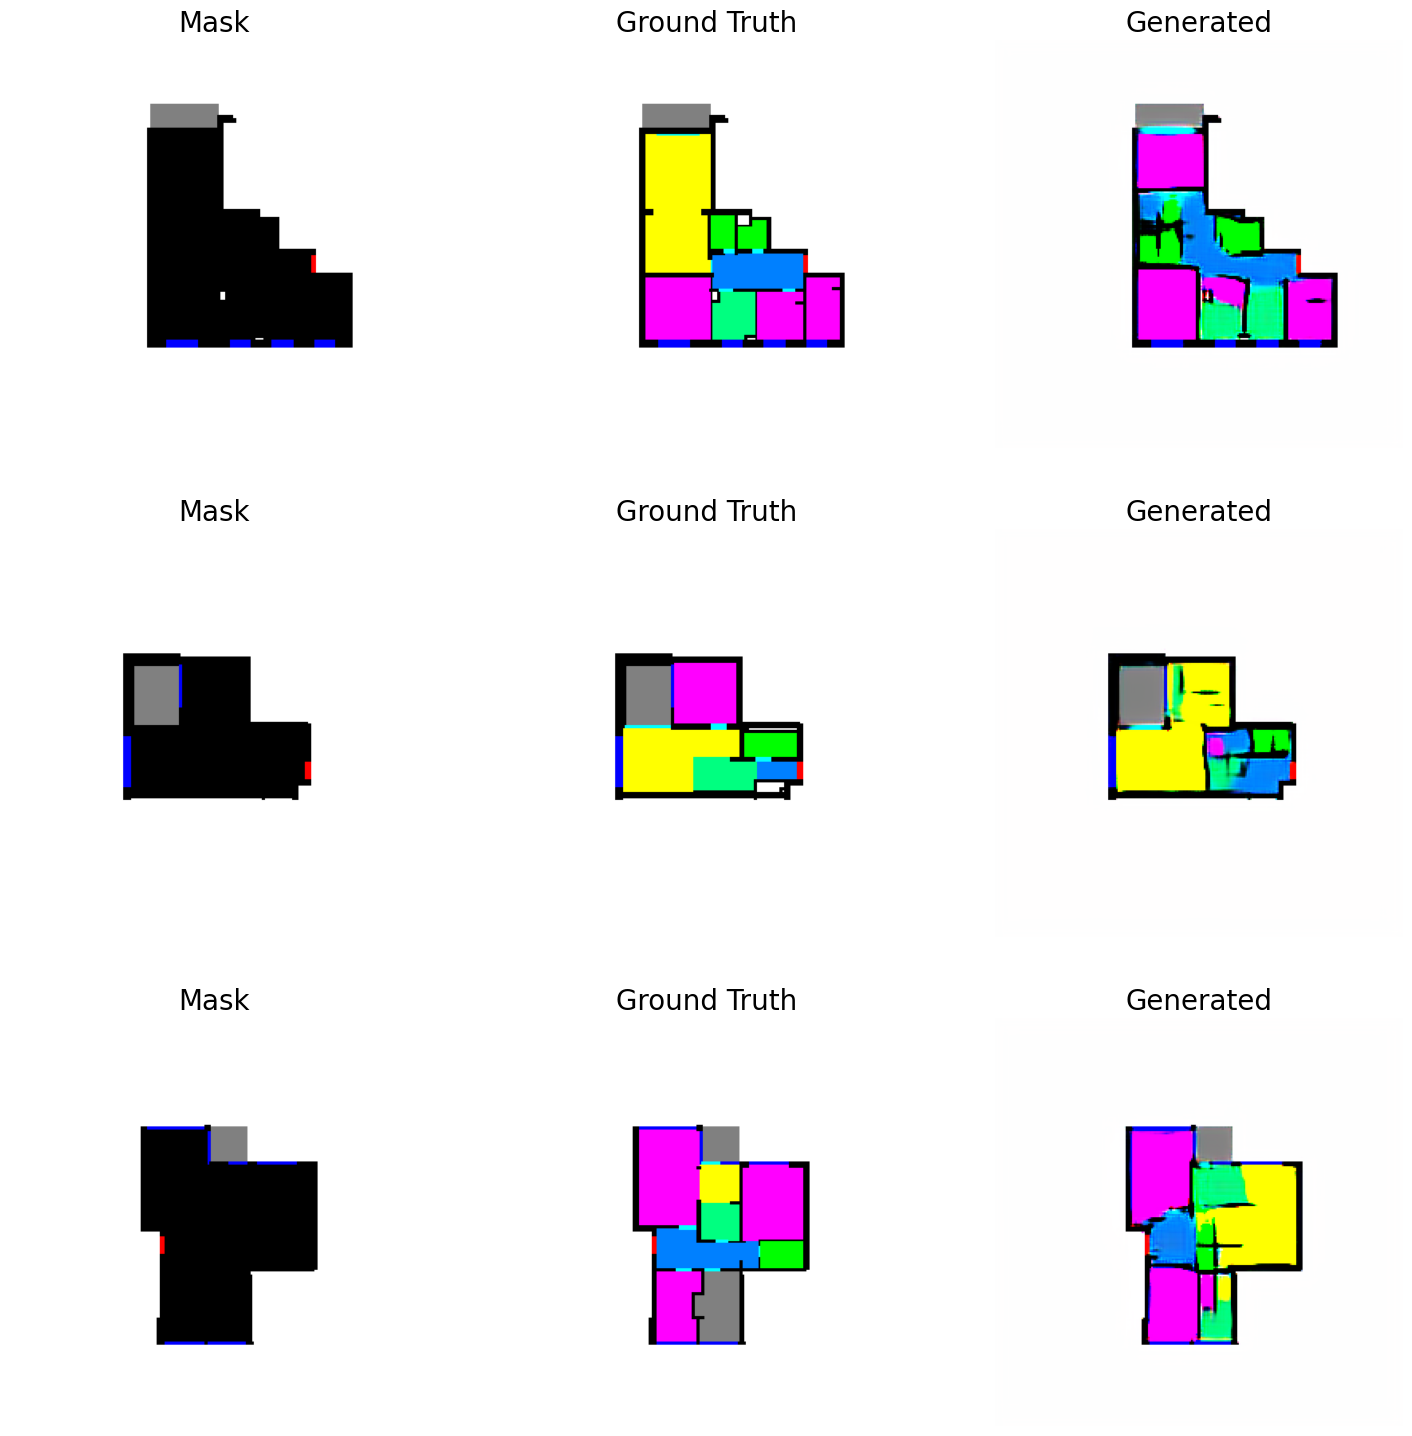

4711/4711 [==============================] - 7850s 2s/step - disc_loss: 0.2422 - gen_loss: 192.7134 - feat_loss: 9.5986 - vgg_loss: 7.4189 - kl_loss: 172.9157 - val_disc_loss: 0.1618 - val_gen_loss: 191.9997 - val_feat_loss: 9.7525 - val_vgg_loss: 7.6311 - val_kl_loss: 172.8758
Epoch 3/10
4711/4711 [==============================] - ETA: 0s - disc_loss: 0.1381 - gen_loss: 193.8643 - feat_loss: 9.9216 - vgg_loss: 7.4357 - kl_loss: 173.0405

1/1 [==============================] - 0s 33ms/step


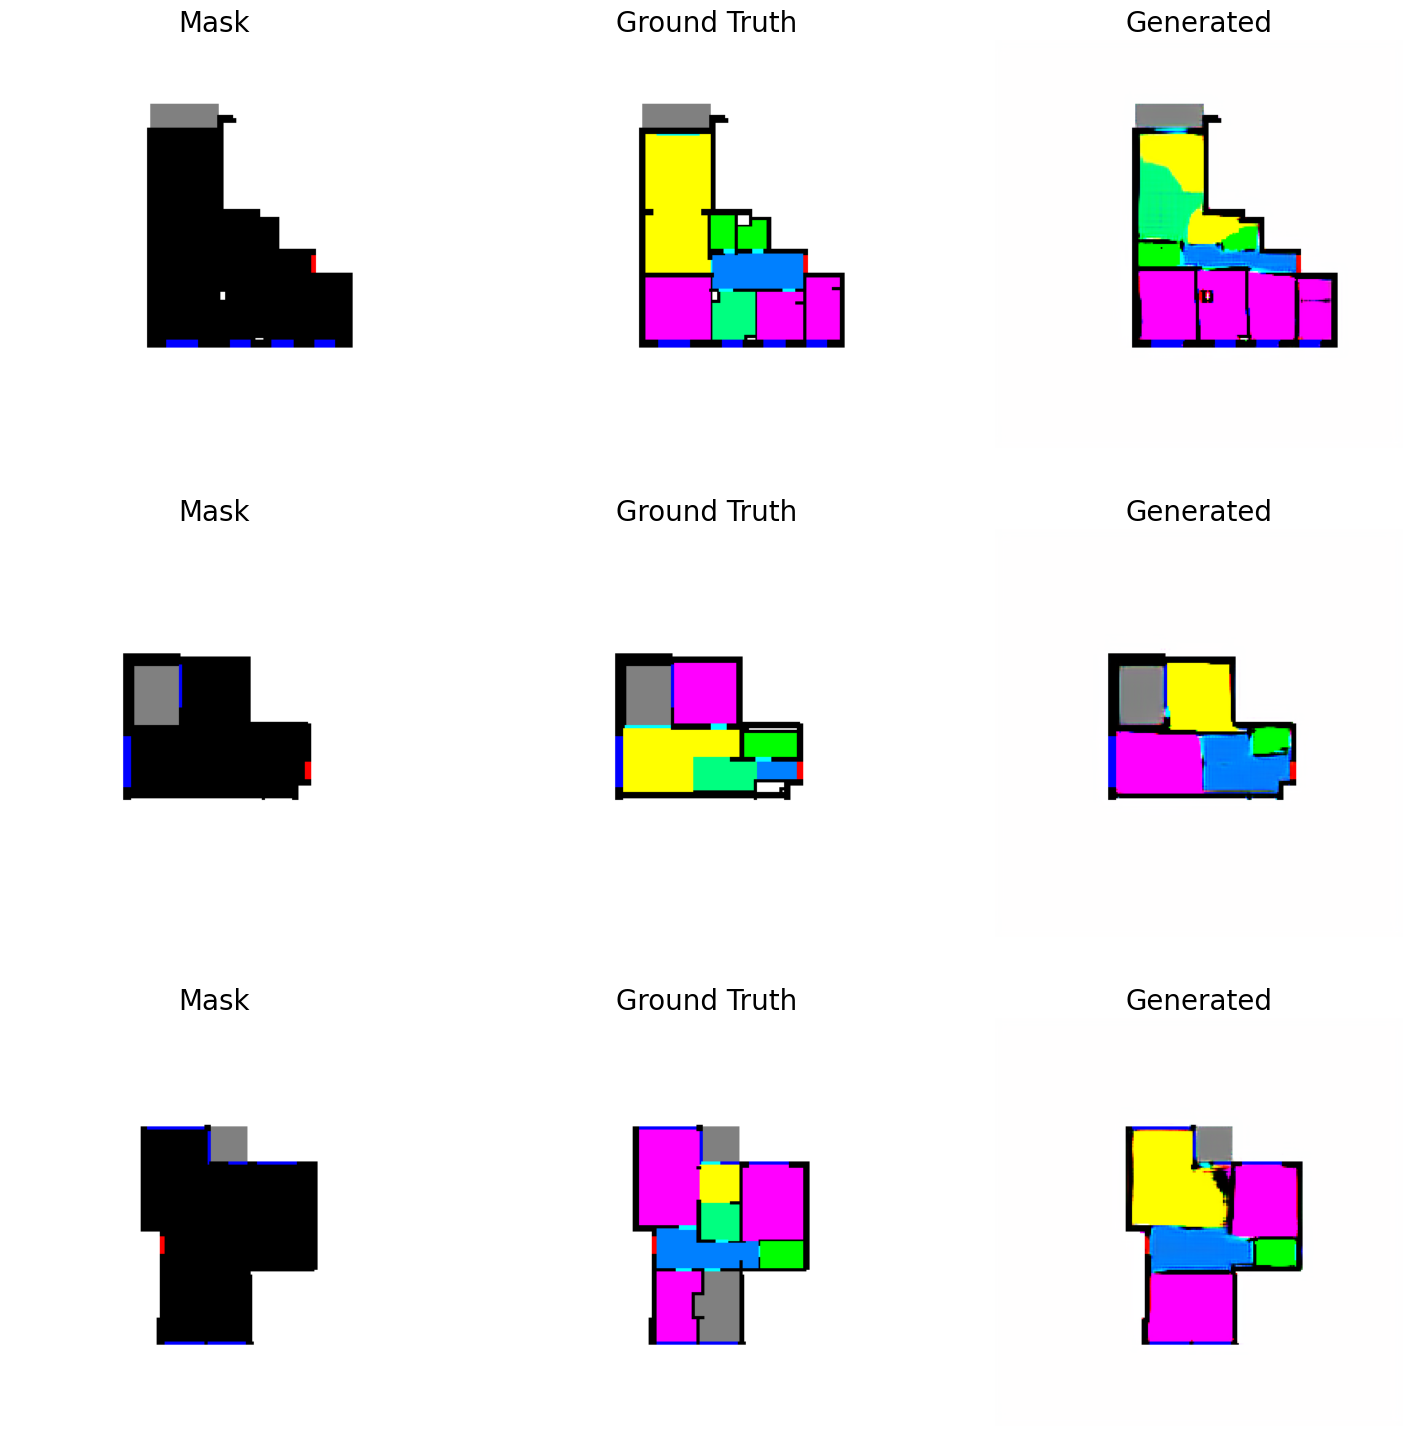

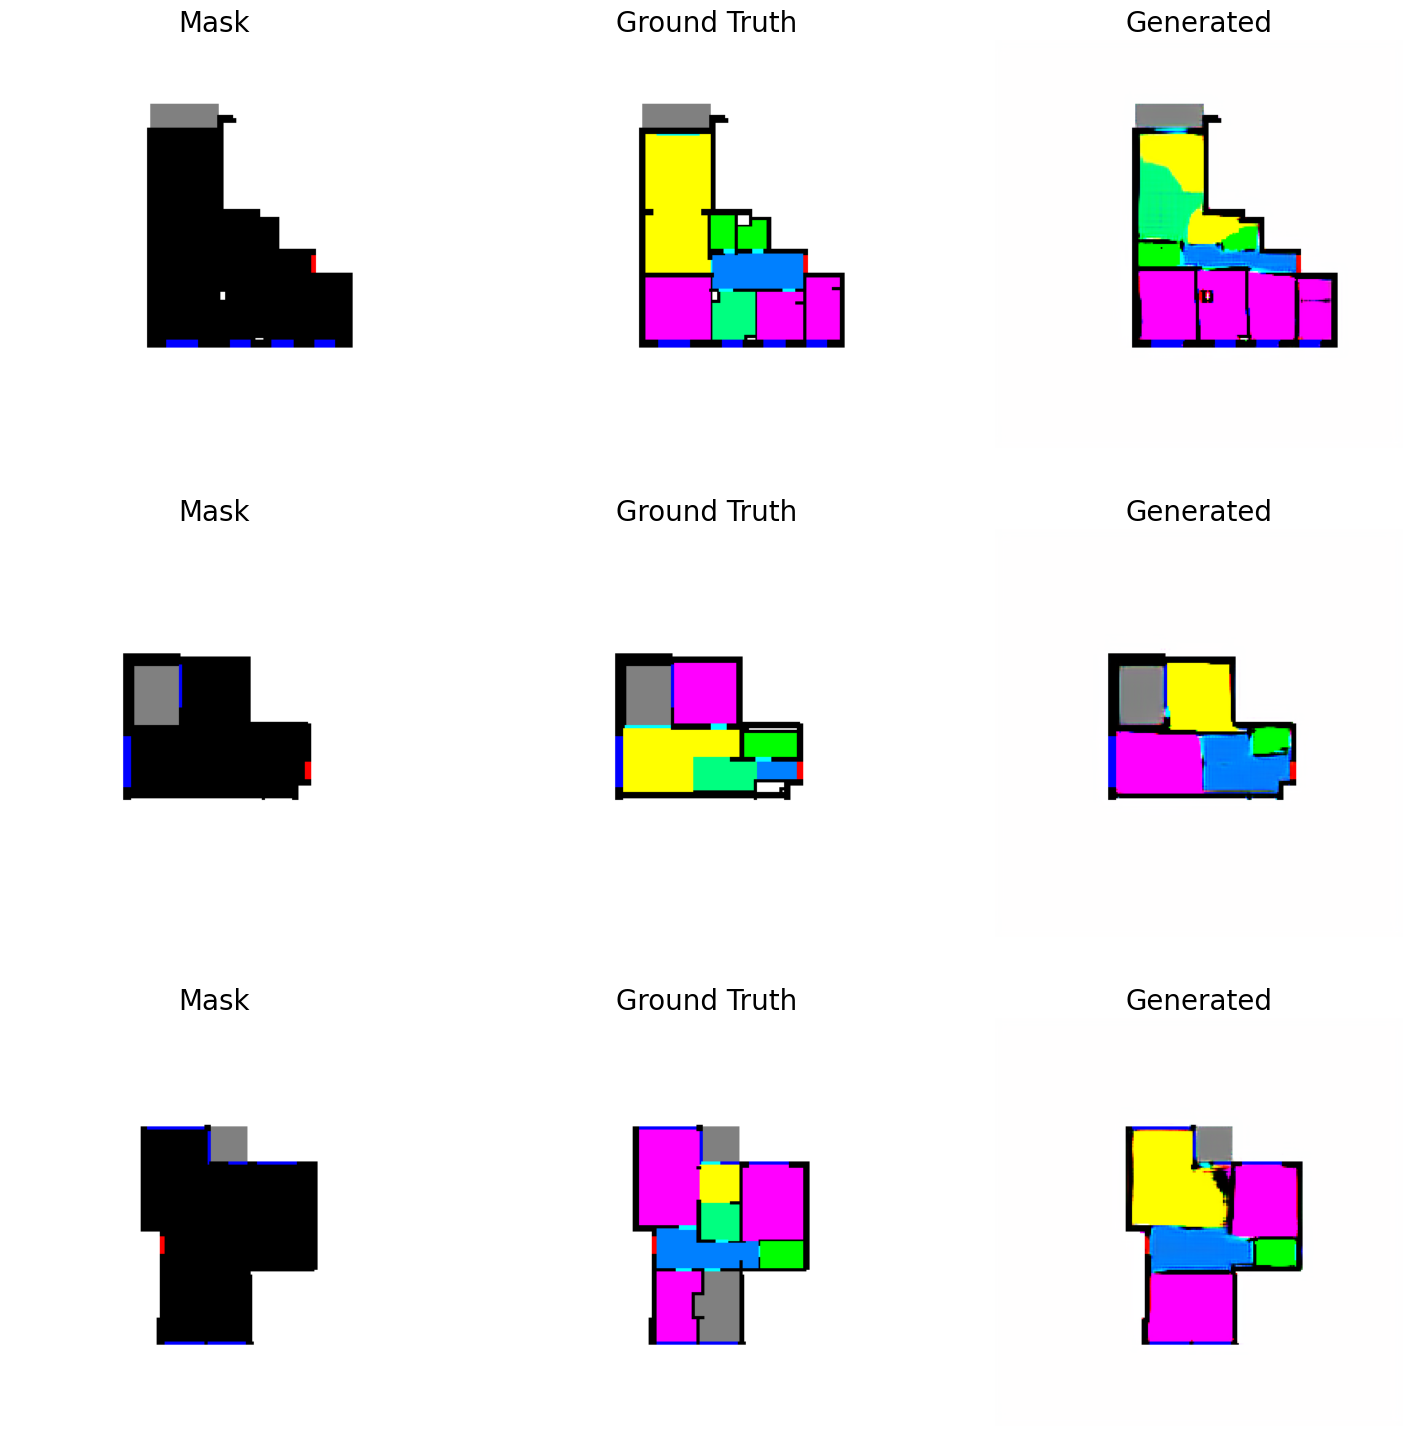

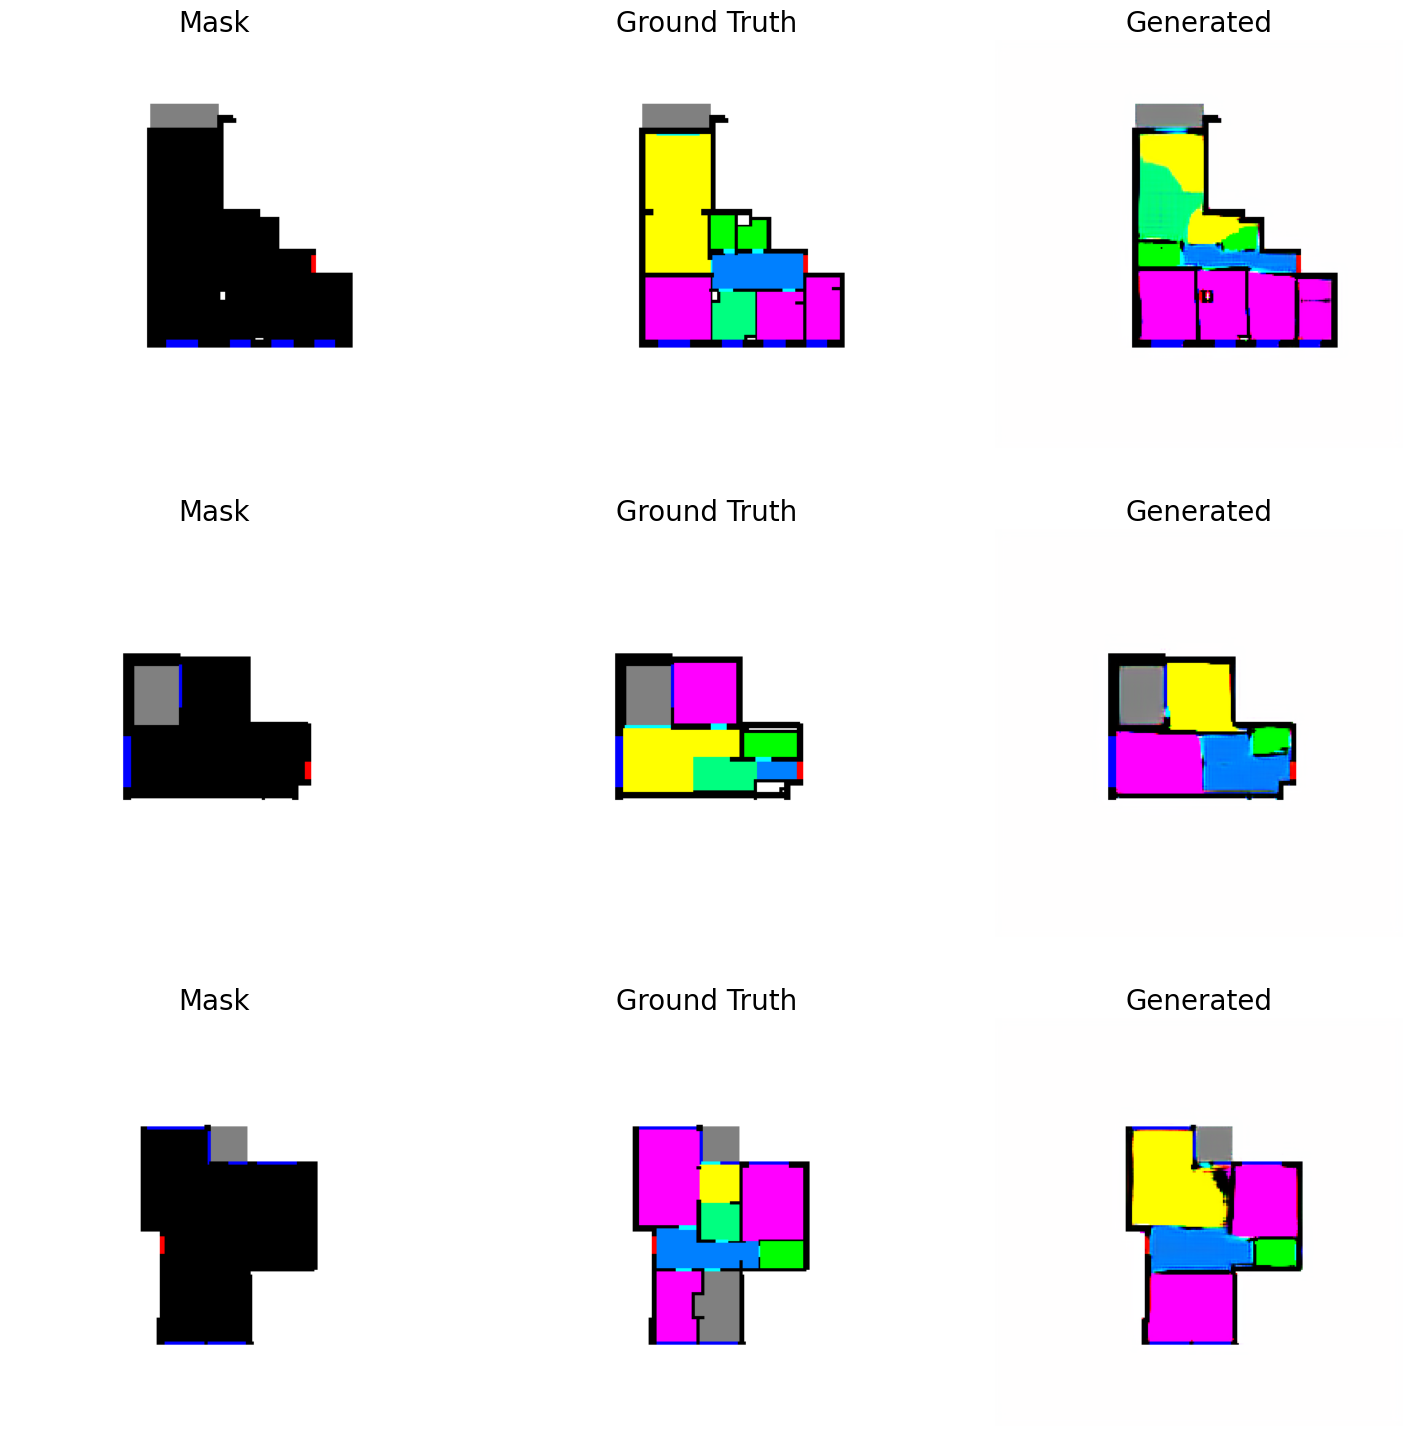

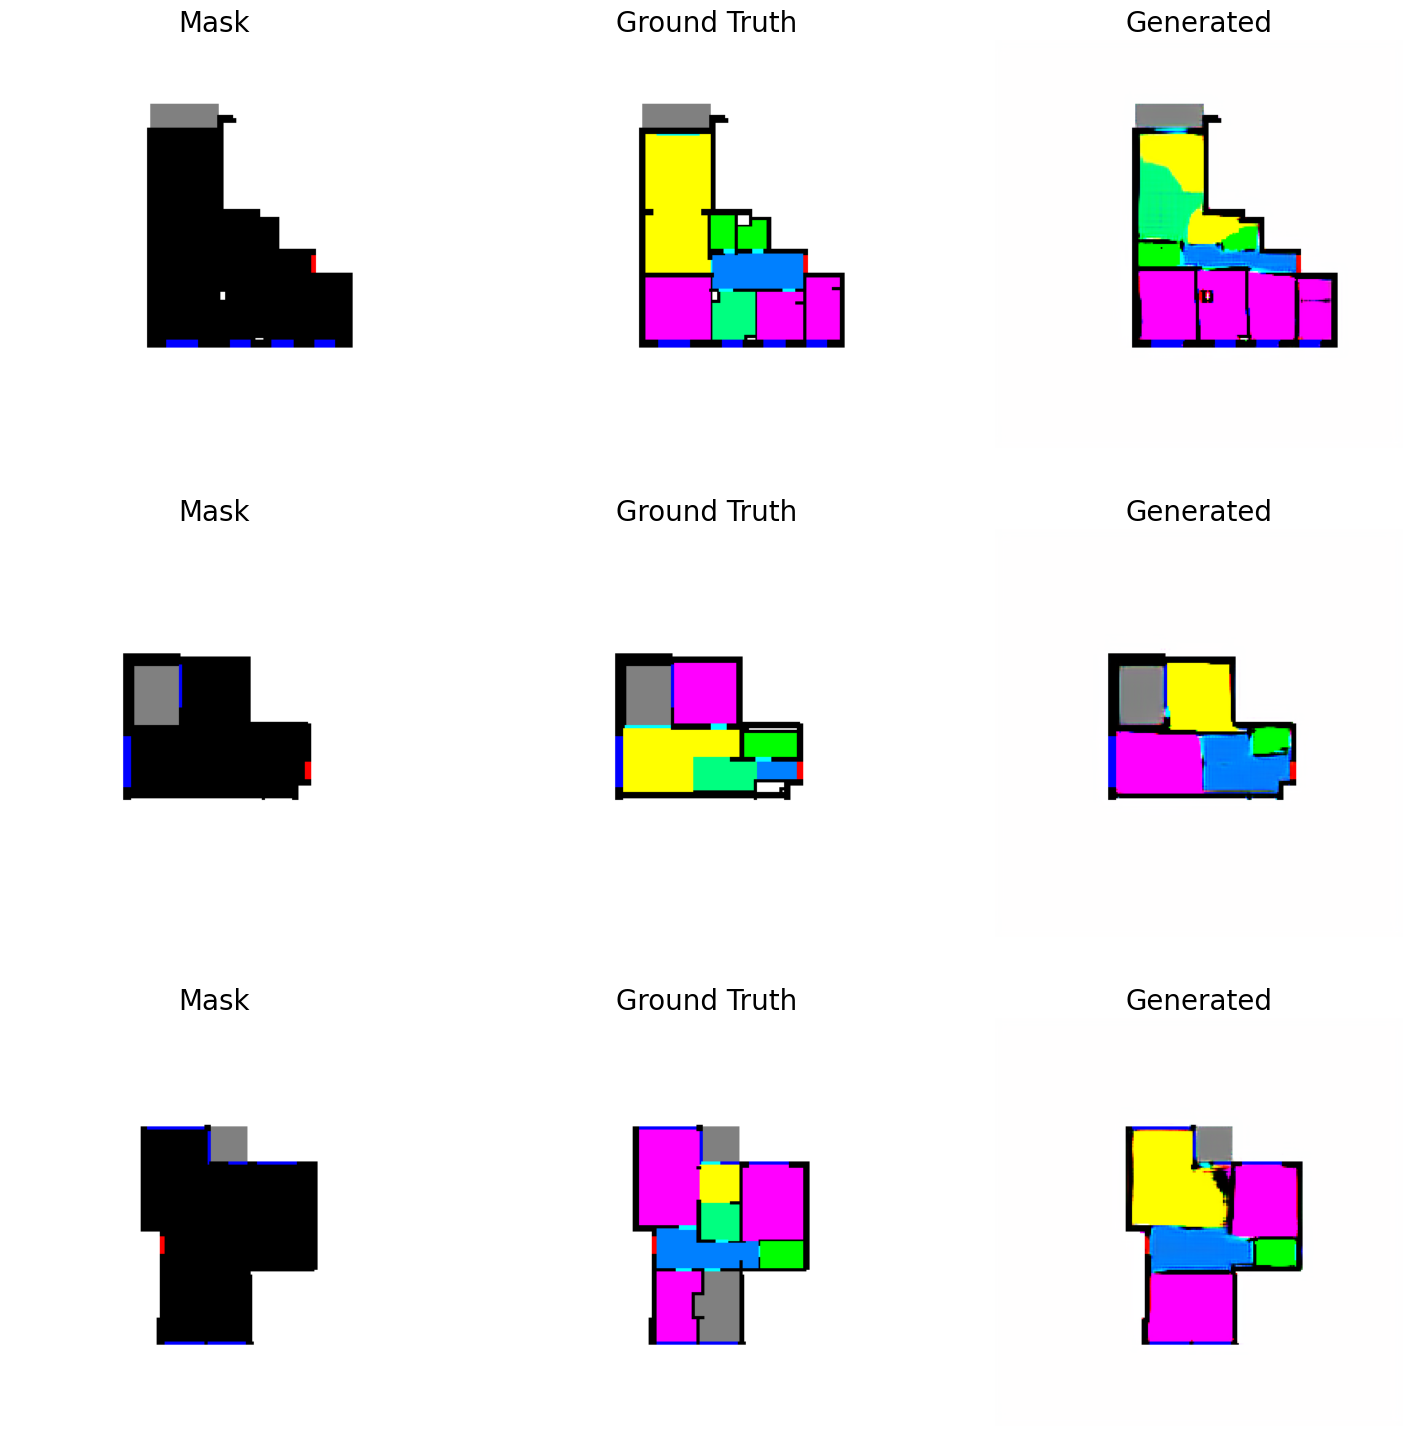

4711/4711 [==============================] - 7803s 2s/step - disc_loss: 0.1381 - gen_loss: 193.8643 - feat_loss: 9.9216 - vgg_loss: 7.4357 - kl_loss: 173.0405 - val_disc_loss: 0.0329 - val_gen_loss: 193.9796 - val_feat_loss: 9.8743 - val_vgg_loss: 7.3886 - val_kl_loss: 173.0348
Epoch 4/10
4305/4711 [==========================>...] - ETA: 10:50 - disc_loss: 0.0918 - gen_loss: 193.9142 - feat_loss: 9.8363 - vgg_loss: 7.3830 - kl_loss: 172.8918

In [ ]:
history = gaugan.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[
        GanMonitor(val_dataset, BATCH_SIZE, epoch_interval = 1),
        SaveCheckpoint()]
    )

In [33]:
now_str = datetime.datetime.now().strftime("%Y%m%d_%H-%M-%S")
checkpoint_path = os.path.join(CHECKPOINT_DIR, f"ckpt_epoch_{now_str}.ckpt")

checkpoint.save(file_prefix=checkpoint_path)

'/content/gdrive/MyDrive/inz_ml_checkpoints/model_vgaugan_02/ckpt_epoch_20240109_13-33-09.ckpt-1'

In [28]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("disc_loss")
plot_history("gen_loss")
plot_history("feat_loss")
plot_history("vgg_loss")
plot_history("kl_loss")

NameError: name 'history' is not defined

## Inference

1/1 [==============================] - 3s 3s/step


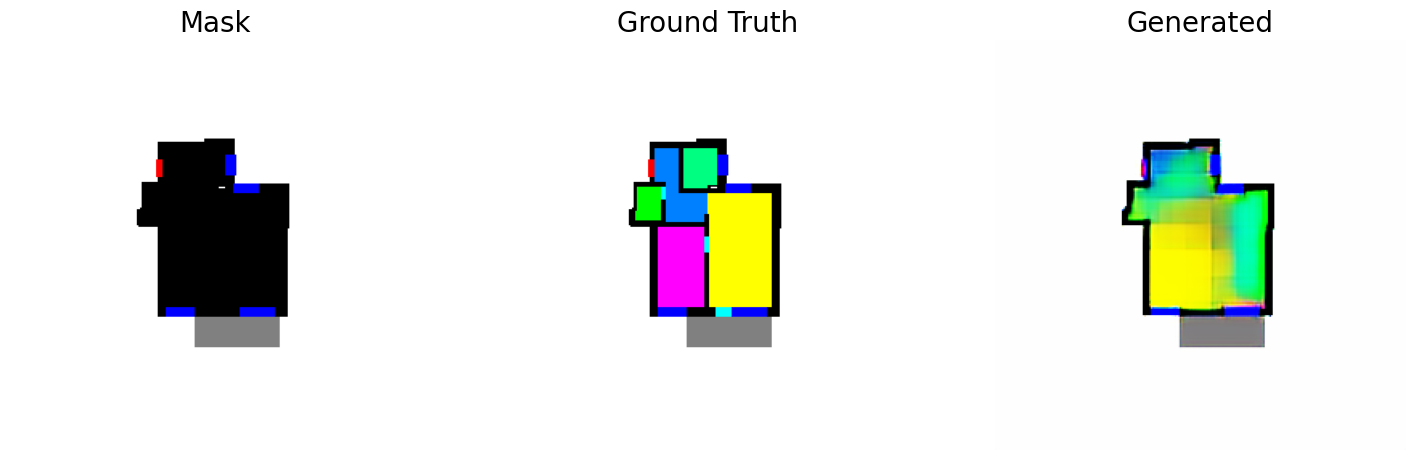

1/1 [==============================] - 0s 134ms/step


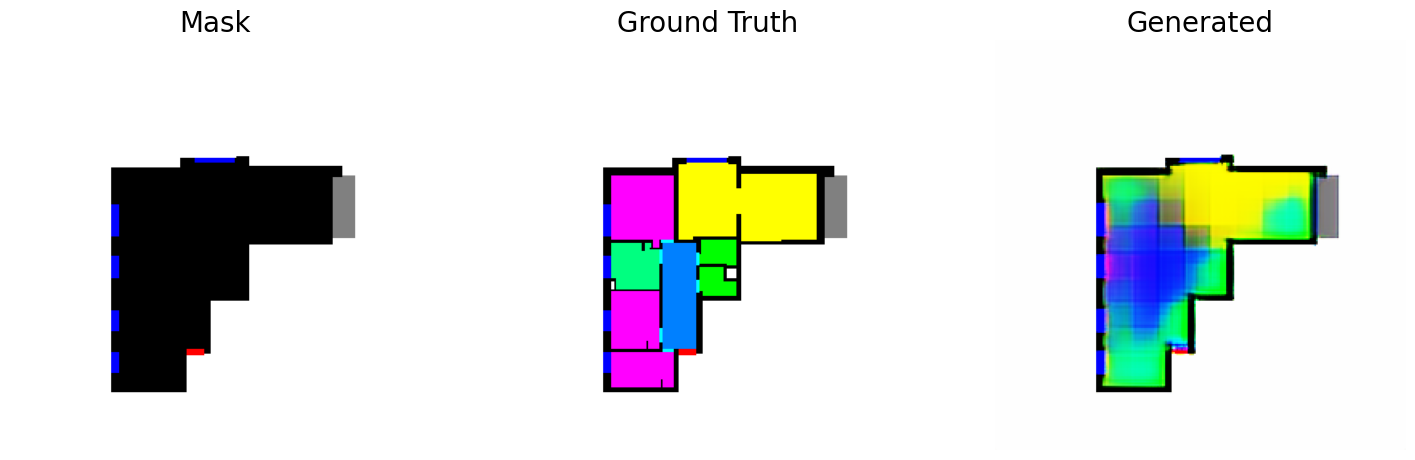

1/1 [==============================] - 0s 40ms/step


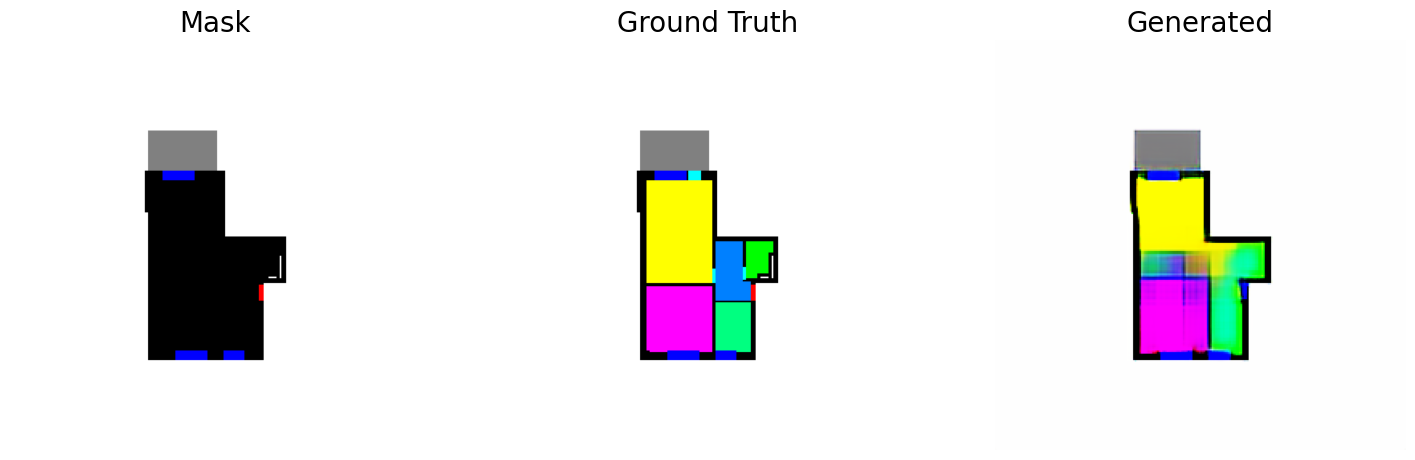

1/1 [==============================] - 0s 43ms/step


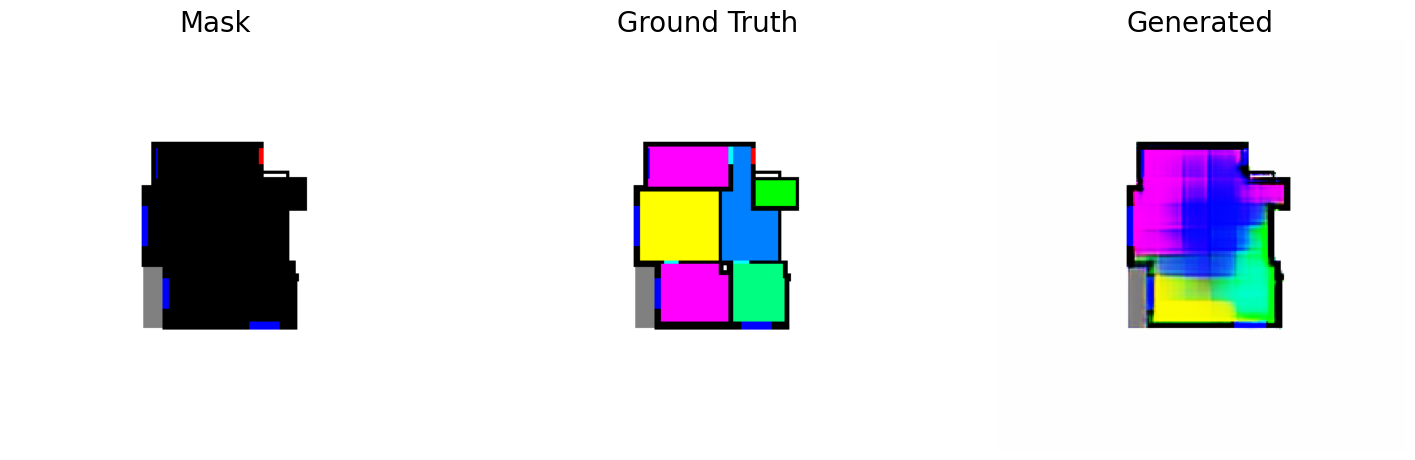

1/1 [==============================] - 0s 51ms/step


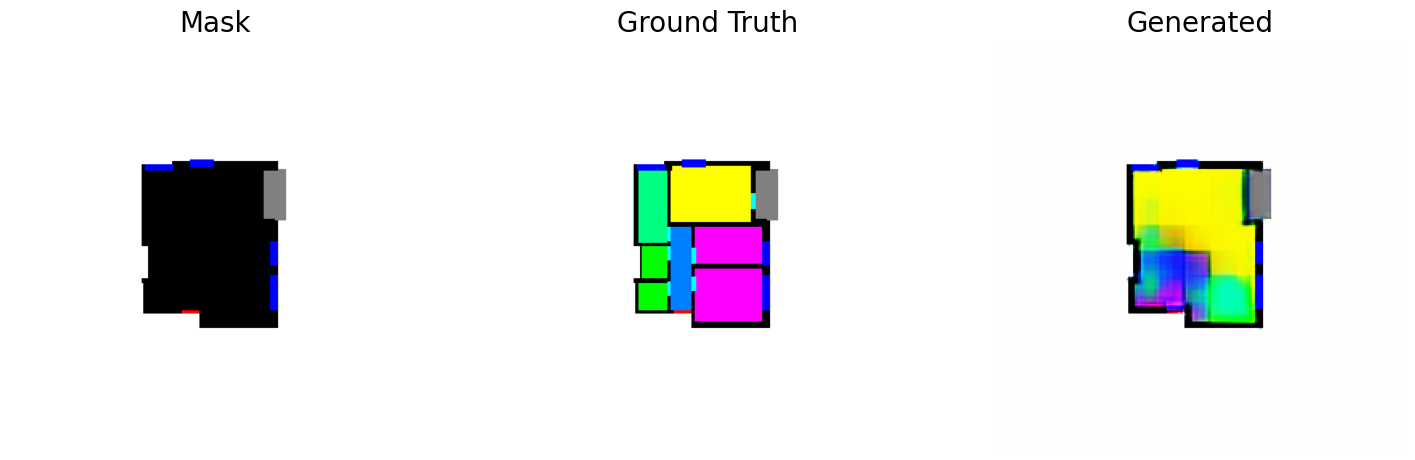

In [51]:
val_iterator = iter(val_dataset)

for _ in range(5):
    val_images = next(val_iterator)
    # Sample latent from a normal distribution.
    latent_vector = tf.random.normal(
        shape=(gaugan.batch_size, gaugan.latent_dim), mean=0.0, stddev=2.0
    )
    # Generate fake images.
    fake_images = gaugan.predict([latent_vector, val_images[2]])

    real_images = val_images
    # grid_row = min(fake_images.shape[0], 3)
    grid_row = 1
    grid_col = 3
    f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col * 6, grid_row * 6))
    for row in range(grid_row):
        ax = axarr if grid_row == 1 else axarr[row]
        ax[0].imshow((real_images[0][row] + 1) / 2)
        ax[0].axis("off")
        ax[0].set_title("Mask", fontsize=20)
        ax[1].imshow((real_images[1][row] + 1) / 2)
        ax[1].axis("off")
        ax[1].set_title("Ground Truth", fontsize=20)
        ax[2].imshow((fake_images[row] + 1) / 2)
        ax[2].axis("off")
        ax[2].set_title("Generated", fontsize=20)
    plt.show()